## Memprediksi Harga Jual Rumah

Tujuan dari proyek ini adalah membangun model Machine Learning untuk memprediksi harga jual rumah berdasarkan berbagai variabel penjelas yang menggambarkan aspek rumah hunian.


### Mengapa ini penting?

Memprediksi harga rumah berguna untuk mengidentifikasi investasi yang menguntungkan atau untuk menentukan apakah harga rumah yang diiklankan di atas atau di bawah perkiraan.


### Apa tujuan dari model Machine Learning?

Bertujuan untuk meminimalkan perbedaan antara harga sebenarnya dan harga yang diperkirakan oleh model. <br>
Model akan mengevaluasi performa model dengan:

1. mean squared error (mse)
2. akar pangkat dua dari kesalahan kuadrat rata-rata (rmse)
3. r-score (r2).

# =============================================================================================

# Solution

# Import Package

In [82]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for the yeo-johnson transformation
import scipy.stats as stats

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

#spliiting data train and test
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

#feature selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# to evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

# Function
def missing(df):
    missing = df.isnull().sum()
    percent = round(100*(missing/df.shape[0]),2)
    types = df.dtypes
    n_unique = df.nunique()
    return pd.DataFrame({"missing":missing,
                        "percent_missing":percent,
                        "types":types,
                        "n_unique":n_unique}).sort_values("percent_missing",ascending=False)

In [2]:
# load dataset
data = pd.read_csv('train.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# drop id, it is just a number given to identify each house
data.drop('Id', axis=1, inplace=True)

data.shape

(1460, 80)

Dataset harga rumah berisi 1460 baris dan 80 kolom

79 adalah variabel prediktif dan 1 adalah variabel target: SalePrice

## Analisis

**Akan dianalisis hal-hal berikut:**

1. Variabel sasaran
2. Jenis variabel (kategorikal dan numerik)
3. Data yang hilang
4. Variabel numerik
     - Diskrit
     - Terus menerus
     - Distribusi
     - Transformasi

5. Variabel kategori
     - Kardinalitas
     - Label Langka
     - Pemetaan khusus

## Sasaran

Mari kita mulai dengan menjelajahi distribusi target.

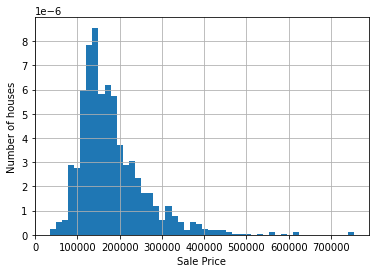

In [4]:
# histogran to evaluate target distribution

data['SalePrice'].hist(bins=50, density=True)
plt.ylabel('Number of houses')
plt.xlabel('Sale Price')
plt.show()

Diamati bahwa distribusi dari rumah mengalami skew positive atau menceng kanan, dan diamati bahwa kebanyakan rumah memiliki harga berkisar 100K hingga 300K

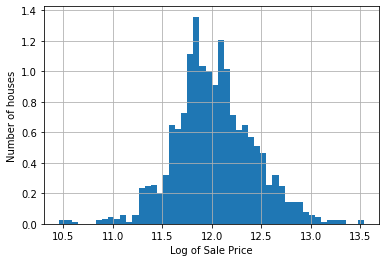

In [5]:
# let's transform the target using the logarithm

np.log(data['SalePrice']).hist(bins=50, density=True)
plt.ylabel('Number of houses')
plt.xlabel('Log of Sale Price')
plt.show()

Diamati bahwa transformasi logaritma memberikan dampak pada persebaran data SalePrice menjadi distribusi normal.

# Missing Values Analysis

In [6]:
#pisahkan variable categorical dan numerical

cat_vars = [var for var in data.columns if data[var].dtype == 'O']

# MSsubClass adalah categorical variable, masukkan ke cat_vars
cat_vars = cat_vars + ['MSSubClass']


num_vars = [
    var for var in data.columns if var not in cat_vars and var != 'SalePrice'
]

In [7]:
missing(data)

,missing,percent_missing,types,n_unique
PoolQC,1453,99.52,object,3
MiscFeature,1406,96.30,object,4
Alley,1369,93.77,object,2
Fence,1179,80.75,object,4
FireplaceQu,690,47.26,object,5
...,...,...,...,...
Heating,0,0.00,object,6
HeatingQC,0,0.00,object,5
MSZoning,0,0.00,object,5
1stFlrSF,0,0.00,int64,753


Diamati pada dataset yang tersedia, banyak fitur yang memiliki missing values yang tinggi, akan dilakukan **Feature Selection** pada variable/feature/kolom yang memiliki missing values lebih dari 50%

In [8]:
#drop feature missing lebih dari 50%
var_drop = [var for var in data.columns if data[var].isnull().sum()/len(data) >=0.5]
var_drop

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [9]:
#drop data
data = data.drop(var_drop,axis=1)

In [10]:
# membuat list baru yang menampung variable nan untuk dianalisis
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]


data[vars_with_na].isnull().mean().sort_values(ascending=False)

FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
MasVnrType      0.005479
MasVnrArea      0.005479
Electrical      0.000685
dtype: float64

In [11]:
#pisahkan data catgorical dan numerikal untuk mempermudah analisa missing
cat_na = [var for var in cat_vars if var in vars_with_na]
num_na = [var for var in num_vars if var in vars_with_na]

print('Number of categorical variables with na: ', len(cat_na))
print('Number of numerical variables with na: ', len(num_na))

Number of categorical variables with na:  12
Number of numerical variables with na:  3


In [12]:
def analyse_na_value(df, var):
    #membuat backup
    df = df.copy()

    #observasi missing values dengan melakukan encoding, 1 adalah missing dan 0 otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    #create grup by untuk analisa rata rata sales price
    tmp = df.groupby(var)['SalePrice'].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Sale Price", color='green')

    plt.show()

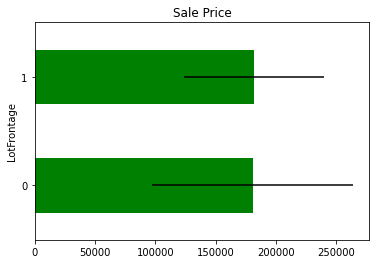

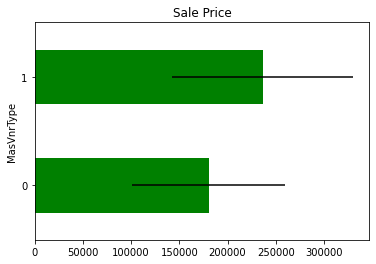

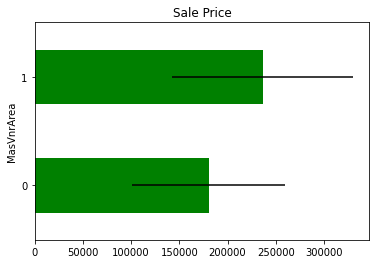

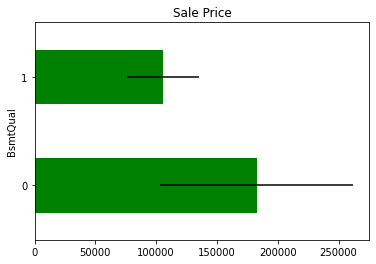

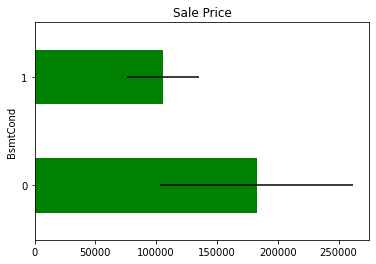

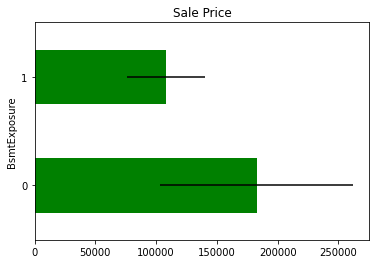

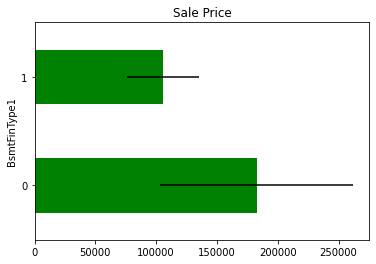

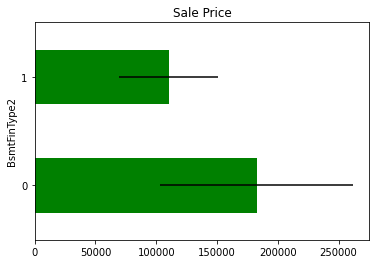

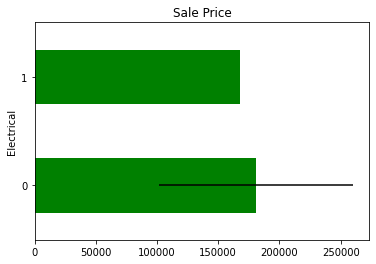

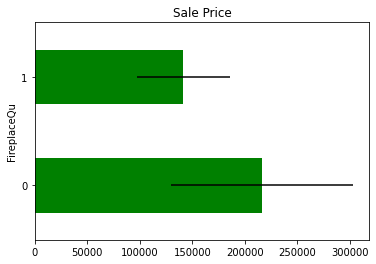

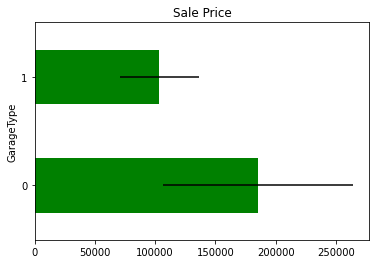

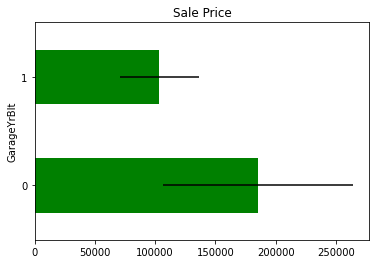

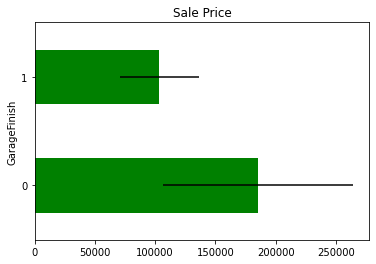

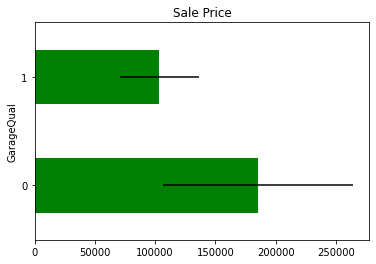

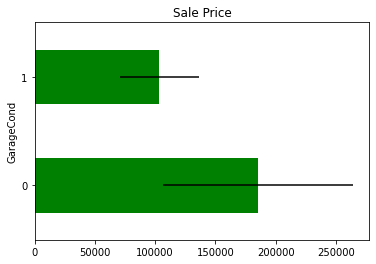

In [13]:
#looping
for var in vars_with_na:
    analyse_na_value(data, var)

Diamati bahwa beberapa variable yang mangandung missing memberikan sebuah informasi, hal ini terlihat dari perbedaan rata ratanya. Variable selain LotFrontAge adalah predictor yang bagus.

# Temporal Variables

Disini kita memiliki 4 variable waktu yaitu : <br>

- YearBuilt: tahun rumah dibangun
- YearRemodAdd: Tahun rumah di perbaiki
- GarageYrBlt:tahun garasi dibangun
- YrSold: tahun rumah di jual

kita dapat mengekstrak informasi pada 4 variable ini untuk di analisis, seperti Umur rumah = YrSold - YearBuilt.

In [14]:
# membuat list variable waktu

year_vars = [var for var in num_vars if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [15]:
#eksplore
for var in year_vars:
    print(var, data[var].unique())
    print()

YearBuilt [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]

YearRemodAdd [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]

GarageYrBlt [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 200

Text(0, 0.5, 'Median House Price')

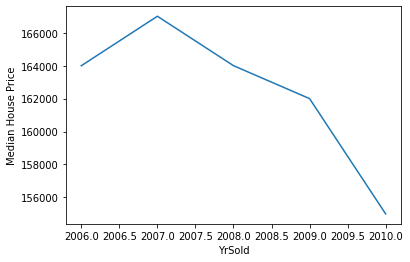

In [16]:
#plot median saleprice


data.groupby('YrSold')['SalePrice'].median().plot()
plt.ylabel('Median House Price')

terdapat keanehan pada sales price, dimana harga rumah semakin turun dari waktu ke waktu, tentu ini tidak wajar, kita memerlukan analisa lebih lanjut untuk memastikan mengapa hal ini bisa terjadi

Text(0, 0.5, 'Median House Price')

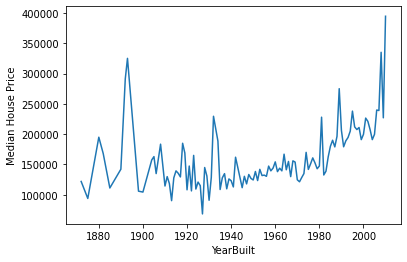

In [17]:
data.groupby('YearBuilt')['SalePrice'].median().plot()
plt.ylabel('Median House Price')

kita melihat bahwa rumah yang lebih **younger** memiliki harga yang semakin mahal

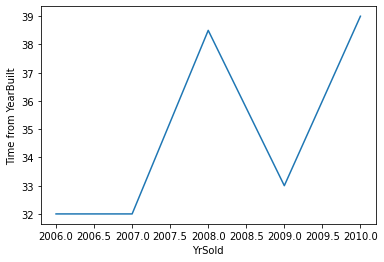

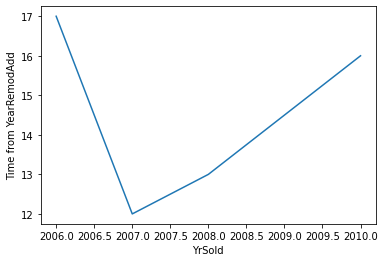

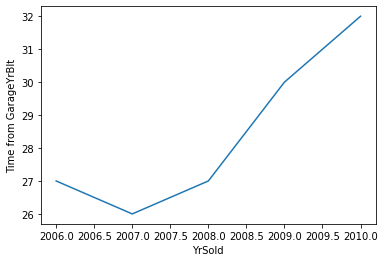

In [18]:
def analyse_year_vars(df, var):
    
    df = df.copy()
    
    df[var] = df['YrSold'] - df[var]
    
    df.groupby('YrSold')[var].median().plot()
    plt.ylabel('Time from ' + var)
    plt.show()
    
    
for var in year_vars:
    if var !='YrSold':
        analyse_year_vars(data, var)

Dari plot, terlihat bahwa menjelang tahun 2010, rumah yang dijual memiliki garasi yang lebih tua, dan belum direnovasi, yang mungkin menjelaskan mengapa  terlihat harga penjualan yang lebih murah dalam beberapa tahun terakhir, setidaknya dalam kumpulan data ini.

Sekarang dapat memplot waktu sejak terakhir direnovasi, atau waktu sejak dibangun, dan harga jual, untuk melihat apakah ada hubungan.

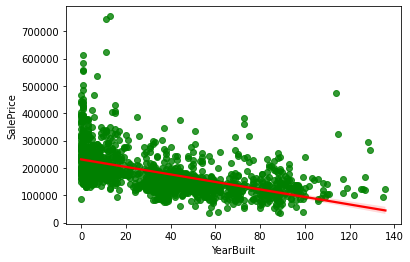

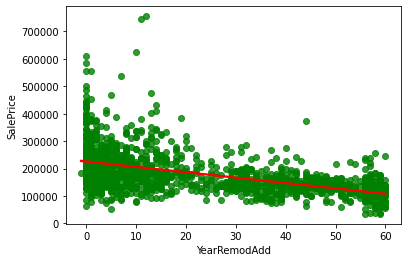

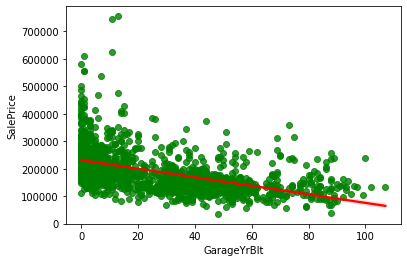

In [19]:
def analyse_year_vars(df, var):
    
    df = df.copy()
    
    df[var] = df['YrSold'] - df[var]
    
    sns.regplot(data=df,x=var, y='SalePrice',
               line_kws={"color":"red"},
               scatter_kws={"color":"g"})
    plt.ylabel('SalePrice')
    plt.xlabel(var)
    plt.show()
    
    
for var in year_vars:
    if var !='YrSold':
        analyse_year_vars(data, var)

Terlihat ada kecenderungan penurunan harga, dengan rumah yang lebih tua. Dengan kata lain, semakin lama waktu antara rumah dibangun atau direnovasi dan tanggal penjualan, semakin rendah harga jualnya.

Yang masuk akal, karena ini berarti rumah tersebut akan terlihat lebih tua, dan berpotensi membutuhkan perbaikan.

# Discreate Variable

In [20]:
# Membuat Variable Discreate
discrete_vars = [var for var in num_vars if len(
    data[var].unique()) < 20 and var not in year_vars]


print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  13


Variabel diskrit ini cenderung berupa kualifikasi (Qual) atau skala penilaian (Cond), atau mengacu pada jumlah kamar, atau unit (FullBath, GarageCars), atau menunjukkan luas ruangan (KitchenAbvGr).

tentu diharapkan harga yang lebih tinggi, dengan jumlah yang lebih besar.

MoSold adalah bulan di mana rumah dijual.

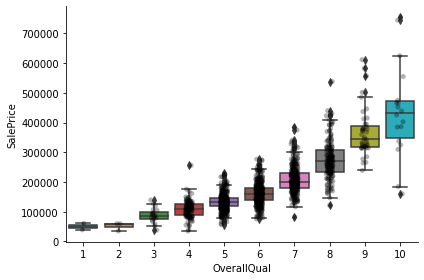

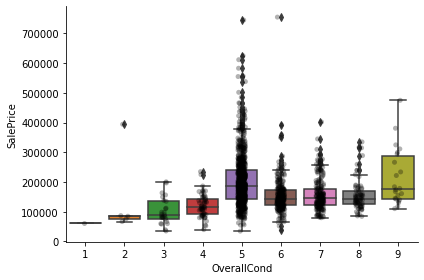

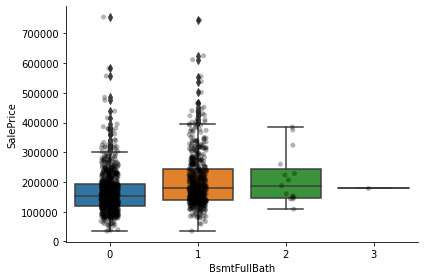

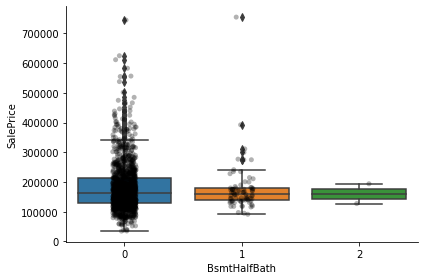

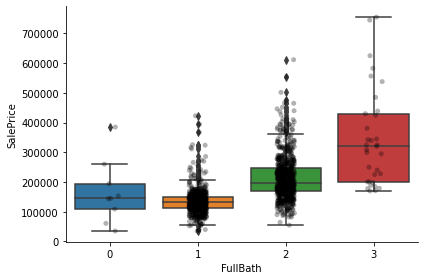

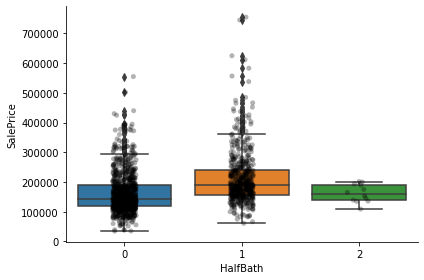

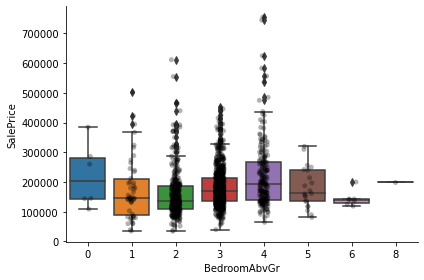

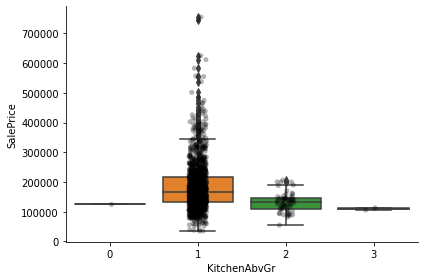

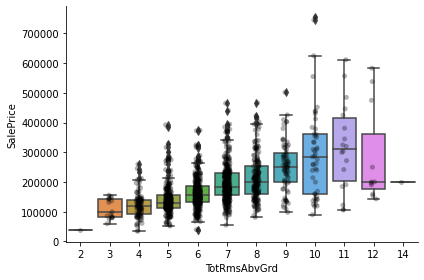

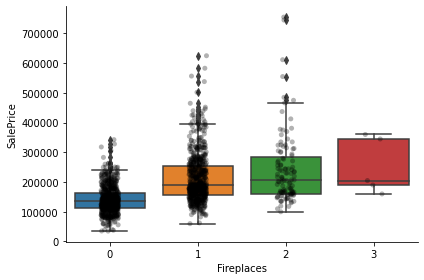

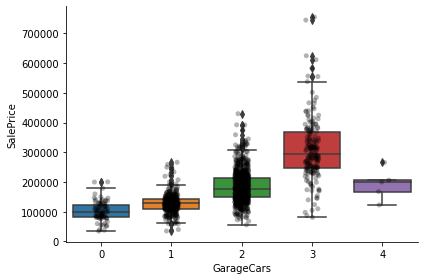

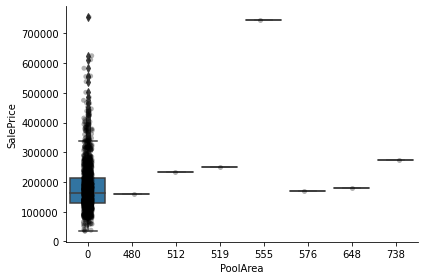

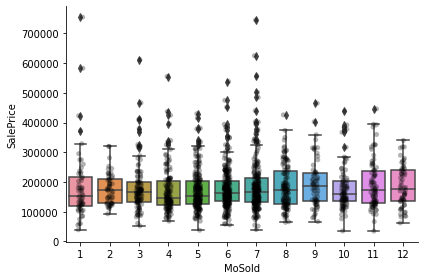

In [21]:
for var in discrete_vars:
    # make boxplot with Catplot
    sns.catplot(x=var, y='SalePrice', data=data, kind="box", height=4, aspect=1.5)
    # add data points to boxplot with stripplot
    sns.stripplot(x=var, y='SalePrice', data=data, jitter=0.1, alpha=0.3, color='k')
    plt.show()

Untuk sebagian besar variabel numerik diskrit, terlihat adanya peningkatan harga jual, dengan kualitas, atau kondisi keseluruhan, atau jumlah ruangan, atau permukaan.

Untuk beberapa variabel, tidak terlihat kecenderungan ini. Kemungkinan besar variabel tersebut bukanlah prediktor harga jual yang baik.

# Continuos

In [22]:
# make list of continuous variables
cont_vars = [
    var for var in num_vars if var not in discrete_vars+year_vars]

print('Number of continuous variables: ', len(cont_vars))

Number of continuous variables:  18


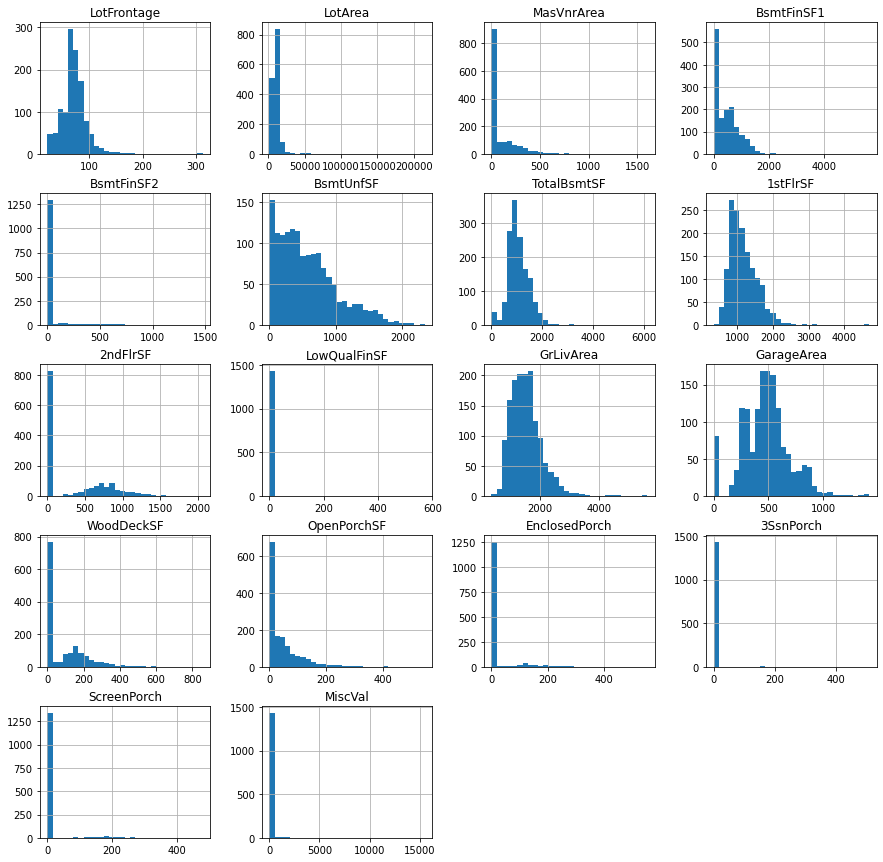

In [23]:
#check ditribusi


data[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

Variabel tidak terdistribusi secara normal. Dan ada beberapa yang sangat skew seperti 3SsnPorch, ScreenPorch dan MiscVal.

Terkadang, mengubah variabel untuk meningkatkan penyebaran nilai, meningkatkan kinerja model. Tetapi tidak mungkin transformasi akan membantu mengubah distribusi variabel super skeww secara dramatis.

Dapat diterapkan transformasi Yeo-Johnson ke variabel seperti LotFrontage, LotArea, BsmUnfSF, dan transformasi biner ke variabel seperti 3SsnPorch, ScreenPorch, dan MiscVal.

In [24]:
#membuat list variable skew

skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]


#membuat list variable continuous
cont_vars = [
    'LotFrontage',
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
]

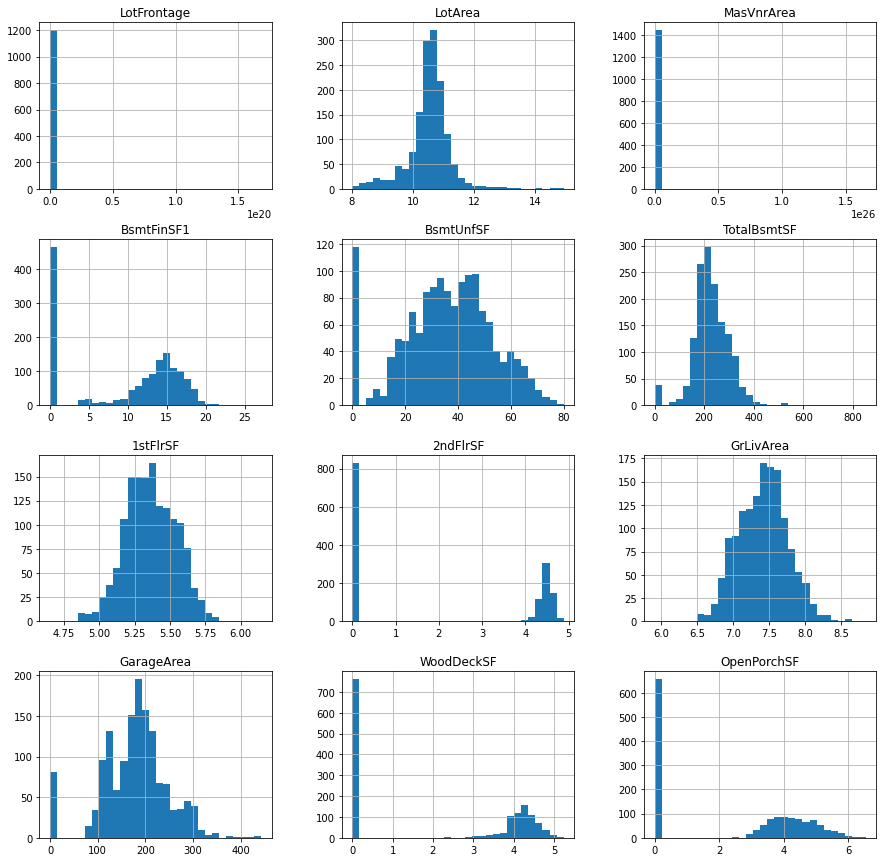

In [25]:
# temporary copy of the data
tmp = data.copy()

for var in cont_vars:

    # transform the variable - yeo-johsnon
    tmp[var], param = stats.yeojohnson(data[var])

    
# plot the histograms of the transformed variables
tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

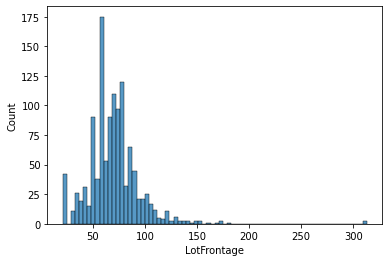

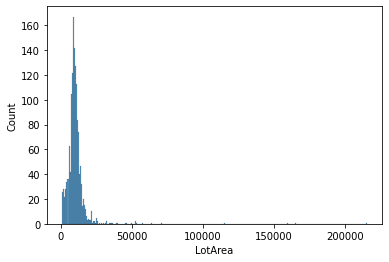

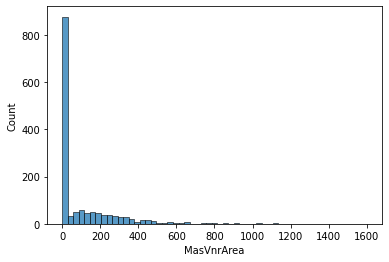

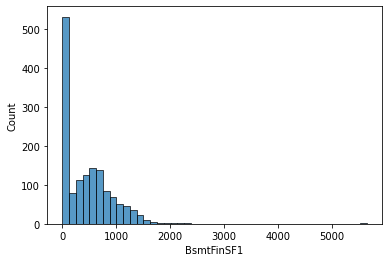

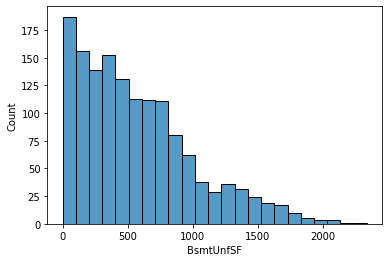

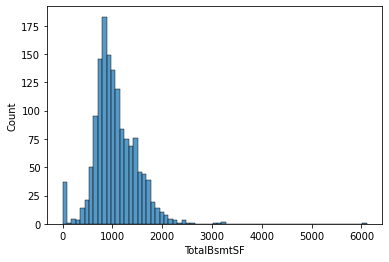

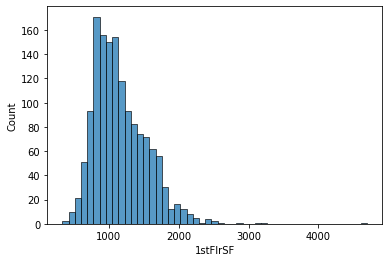

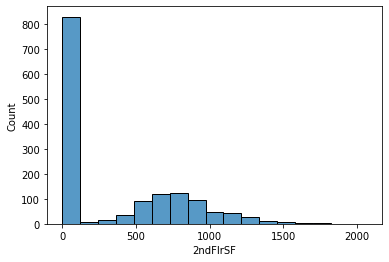

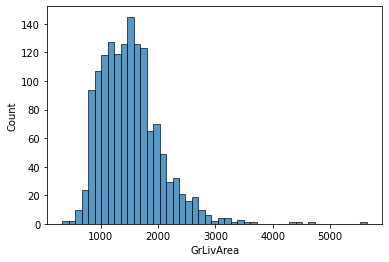

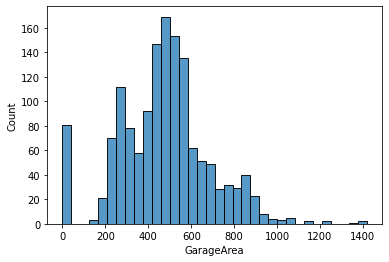

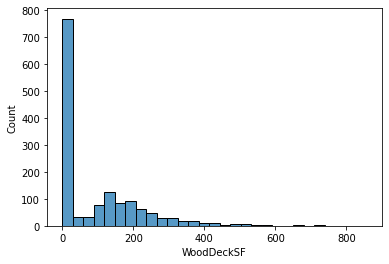

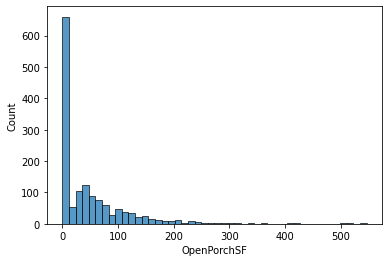

In [26]:
# temporary copy of the data
tmp = data.copy()

for var in cont_vars:
   
    # plot the histograms of the transformed variables
    plt.figure()
    sns.histplot(tmp[var])
    plt.show()

Untuk LotFrontage transformasi yeo-johnson tidak berdampak, tetapi transformasi log memberikan dampak pada distribusinya dan MasVnrArea, transformasi tidak berdampak signifikant.

Bagi yang lain, nilai tampaknya tersebar lebih merata dalam rentang tersebut.

Apakah ini membantu meningkatkan daya prediksi ? masih harus dilihat. Untuk menentukan apakah kasus ini, kita harus melatih model dengan nilai asli dan model dengan nilai yang telah di transformasi, dan menentukan performa model, dan feature importance.

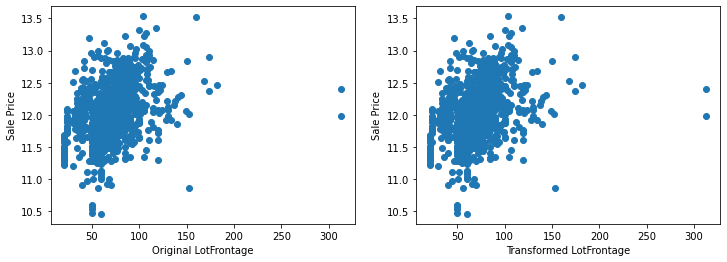

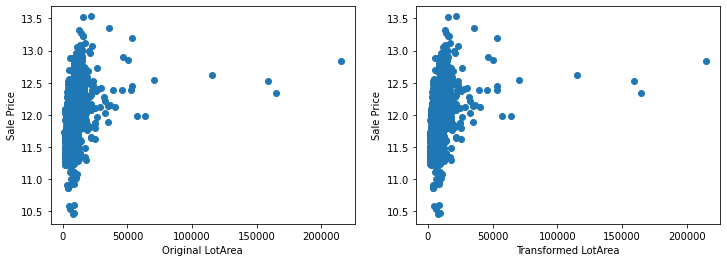

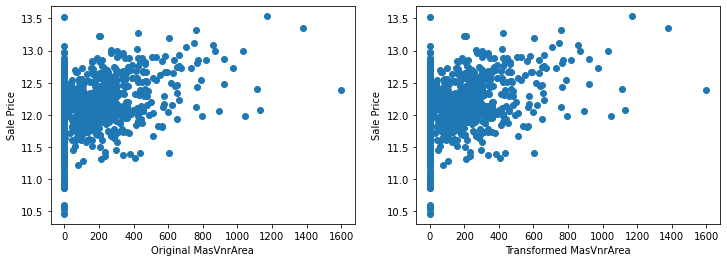

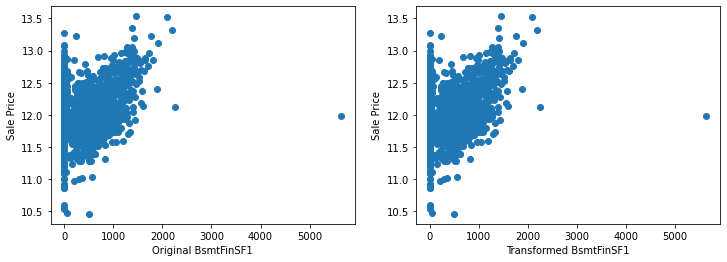

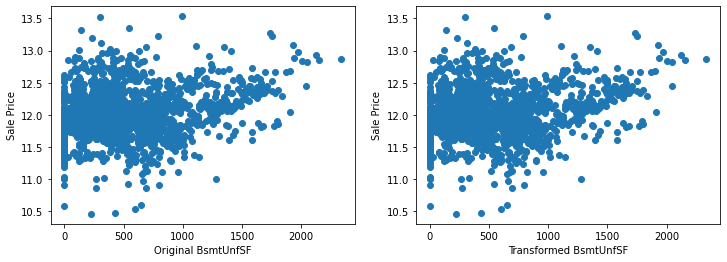

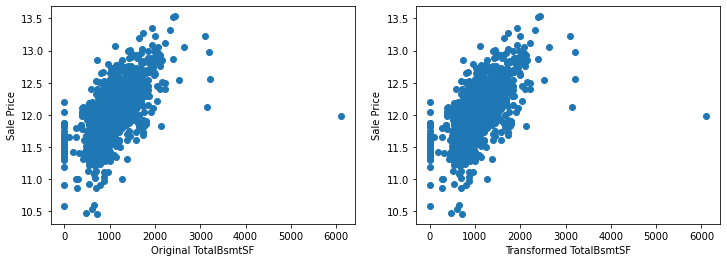

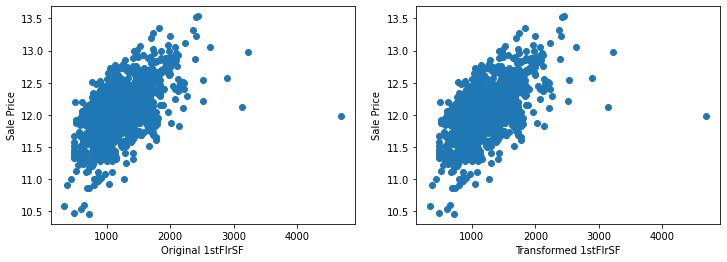

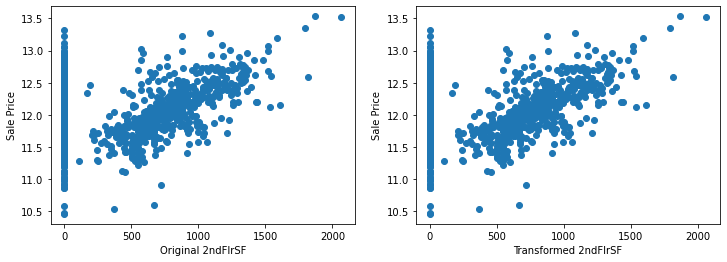

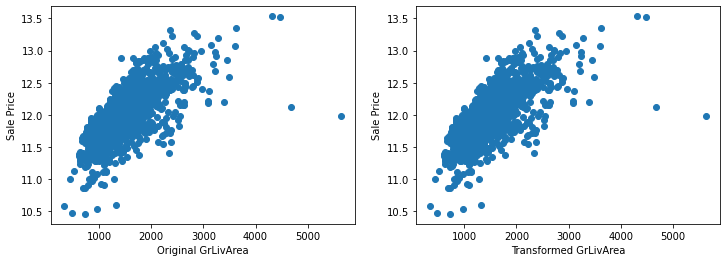

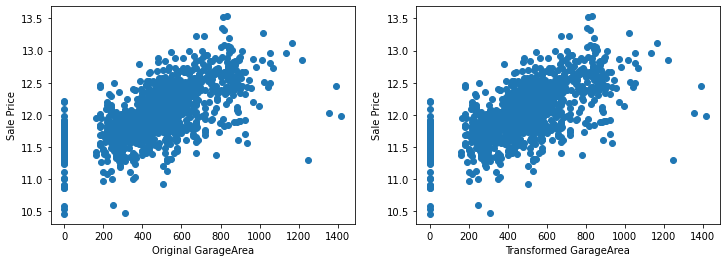

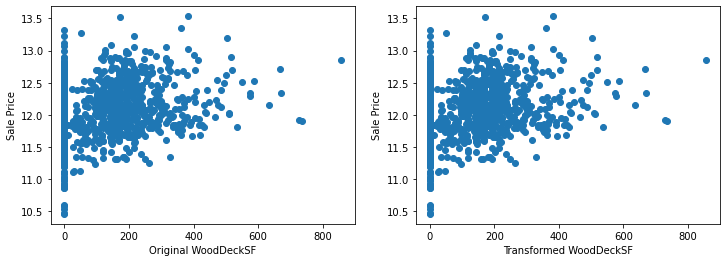

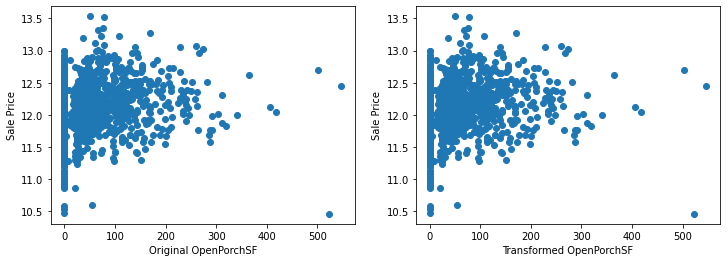

In [27]:
#transform log
for var in cont_vars:
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    plt.scatter(data[var], np.log(data['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(tmp['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Transformed ' + var)
                
    plt.show()

Secara kasat mata, transformasi tampaknya meningkatkan hubungan hanya untuk LotArea.

Mari kita coba transformasi yang berbeda sekarang. Sebagian besar variabel berisi nilai 0, sehingga kita tidak dapat menerapkan transformasi logaritma, tetapi kita pasti dapat melakukannya untuk variabel berikut:

  ["LotFrontage", "1stFlrSF", "GrLivArea"]


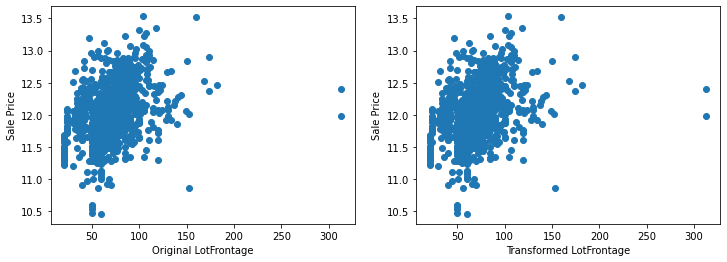

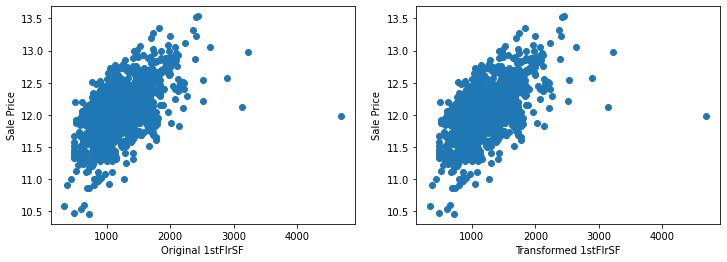

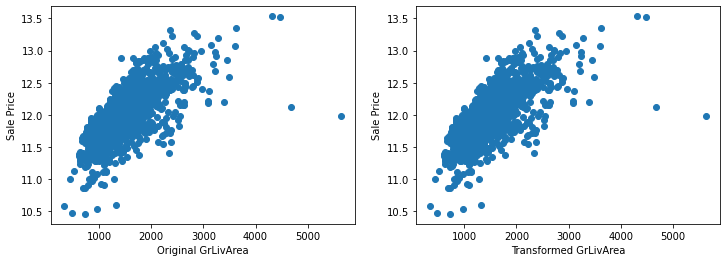

In [28]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    plt.scatter(data[var], np.log(data['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(tmp['SalePrice']))
    plt.ylabel('Sale Price')
    plt.xlabel('Transformed ' + var)
                
    plt.show()

Variabel yang diubah memiliki sebaran nilai yang lebih baik, yang pada gilirannya dapat membantu membuat prediksi yang lebih baik.

# Skew Variables

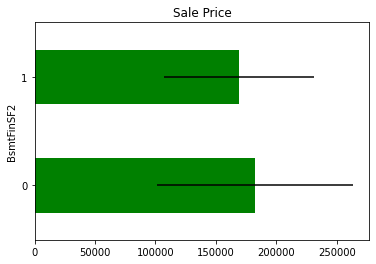

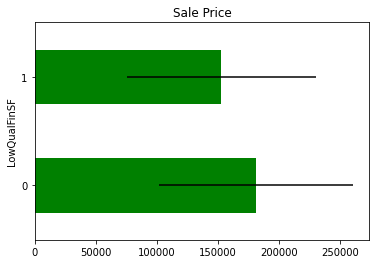

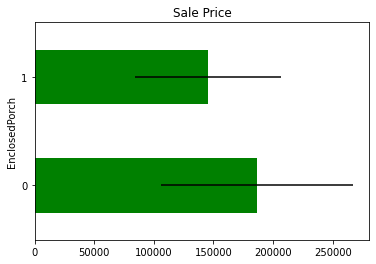

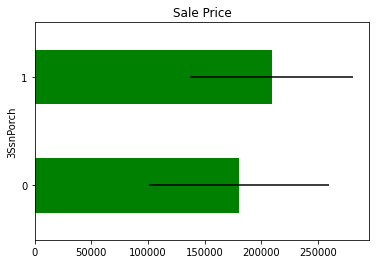

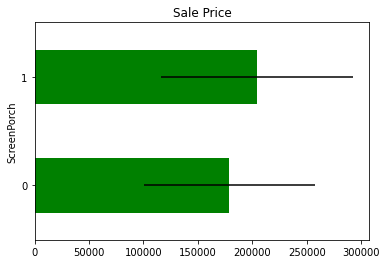

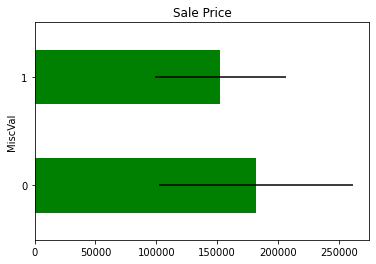

In [29]:
for var in skewed:
    
    tmp = data.copy()
    
    # map the variable values into 0 and 1
    tmp[var] = np.where(data[var]==0, 0, 1)
    
    # determine mean sale price in the mapped values
    tmp = tmp.groupby(var)['SalePrice'].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Sale Price", color='green')

    plt.show()

Tampaknya ada perbedaan Harga Jual pada nilai yang dipetakan, tetapi interval kepercayaan tumpang tindih, sehingga kemungkinan besar hal ini tidak signifikan atau prediktif.

# Categorical Variable

## Number of labels: cardinality

In [30]:
cat_vars = data.select_dtypes(exclude=["float","int"]).columns.tolist()

cat_vars = cat_vars + ['MSSubClass']
print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  40


<AxesSubplot: >

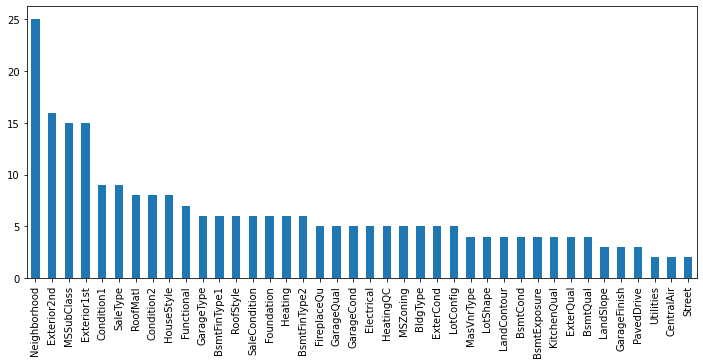

In [31]:
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

Semua variabel kategori menunjukkan kardinalitas yang rendah, ini berarti hanya memiliki beberapa label yang berbeda. Itu bagus karena kita tidak perlu menangani kardinalitas

## Variabel Quality

Ada sejumlah variabel yang merujuk pada kualitas beberapa aspek rumah, misalnya garasi, atau pagar, atau dapur. Disini akan dilakukan mapping kategori dengan angka yang meningkat sesuai kualitas tempat atau ruangan.

Salah satu contoh:

- Ex = Luar biasa
- Gd = Baik
- TA = Rata-Rata/Khas
- Fa = Adil
- Po = Buruk

In [32]:
# re-map strings to numbers

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    data[var] = data[var].map(qual_mappings)

In [33]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4, 'Missing': 0, 'NA': 0}

var = 'BsmtExposure'

data[var] = data[var].map(exposure_mappings)

In [34]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    data[var] = data[var].map(finish_mappings)

In [35]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

data[var] = data[var].map(garage_mappings)

In [36]:
# capture all quality variables

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish']

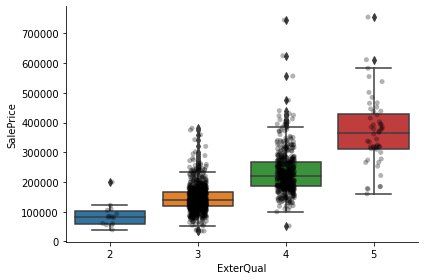

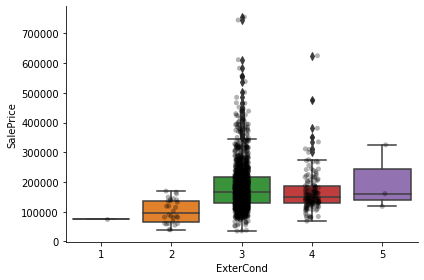

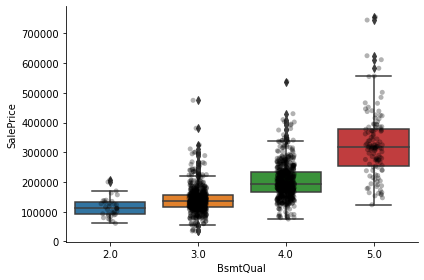

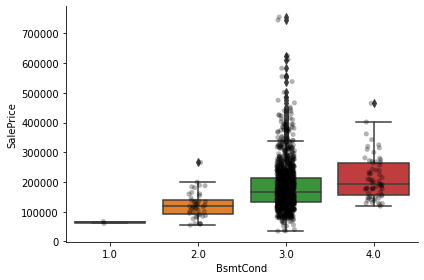

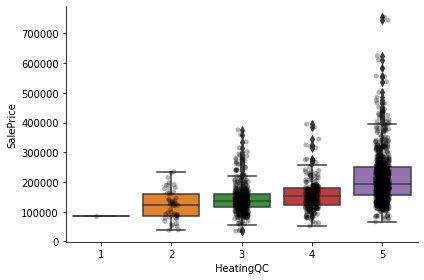

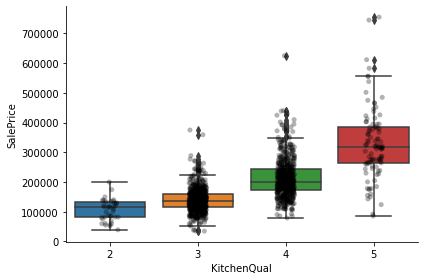

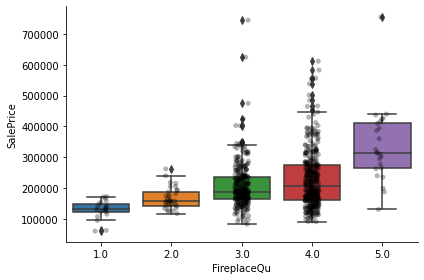

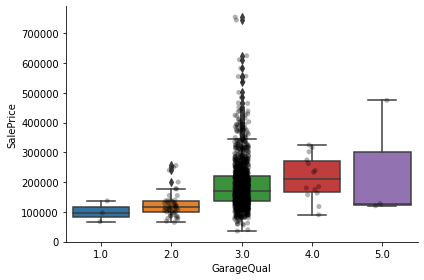

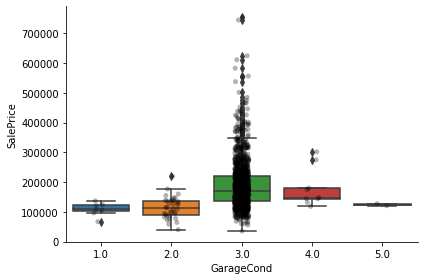

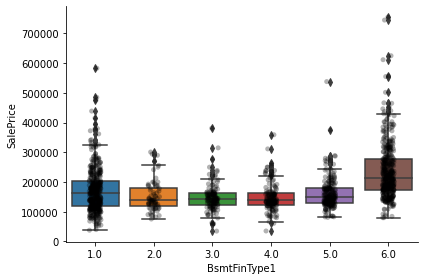

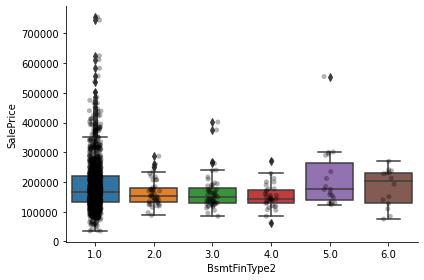

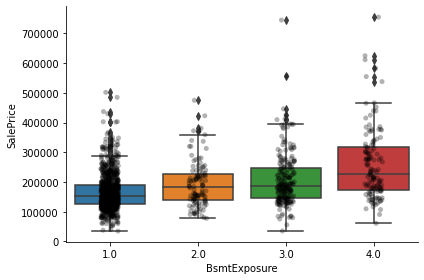

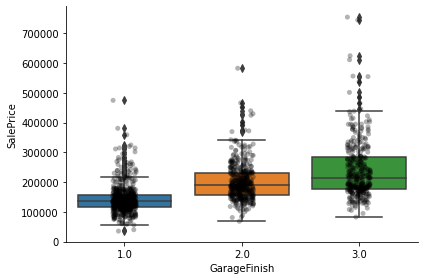

In [37]:
for var in qual_vars:
    sns.catplot(x=var, y='SalePrice', data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=var, y='SalePrice', data=data, jitter=0.1, alpha=0.3, color='k')
    plt.show()

Untuk sebagian besar atribut, kenaikan harga rumah dengan nilai variabelnya cukup jelas.

## Rare labels

In [38]:
cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

27

In [39]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['SalePrice'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations

for var in cat_others:
    print(analyse_rare_labels(data, var, 0.01))
    print()

MSZoning
C (all)    0.006849
Name: SalePrice, dtype: float64

Street
Grvl    0.00411
Name: SalePrice, dtype: float64

LotShape
IR3    0.006849
Name: SalePrice, dtype: float64

Series([], Name: SalePrice, dtype: float64)

Utilities
NoSeWa    0.000685
Name: SalePrice, dtype: float64

LotConfig
FR3    0.00274
Name: SalePrice, dtype: float64

LandSlope
Sev    0.008904
Name: SalePrice, dtype: float64

Neighborhood
Blueste    0.001370
NPkVill    0.006164
Veenker    0.007534
Name: SalePrice, dtype: float64

Condition1
PosA    0.005479
RRAe    0.007534
RRNe    0.001370
RRNn    0.003425
Name: SalePrice, dtype: float64

Condition2
Artery    0.001370
Feedr     0.004110
PosA      0.000685
PosN      0.001370
RRAe      0.000685
RRAn      0.000685
RRNn      0.001370
Name: SalePrice, dtype: float64

Series([], Name: SalePrice, dtype: float64)

HouseStyle
1.5Unf    0.009589
2.5Fin    0.005479
2.5Unf    0.007534
Name: SalePrice, dtype: float64

RoofStyle
Flat       0.008904
Gambrel    0.007534
Mansard  

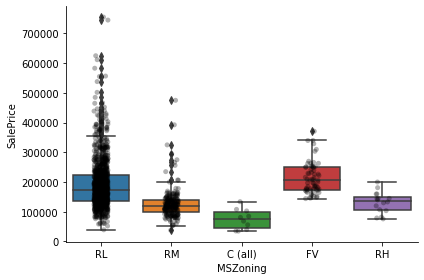

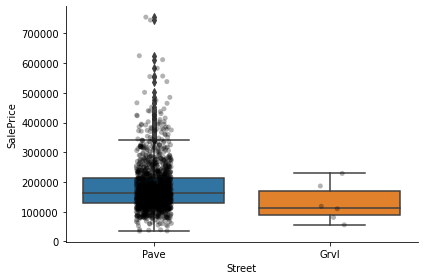

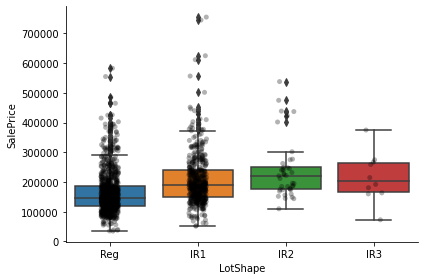

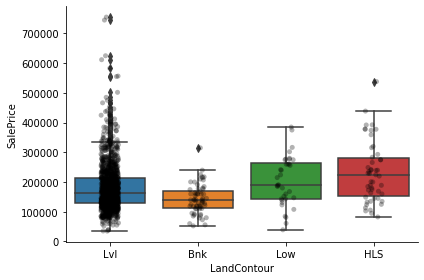

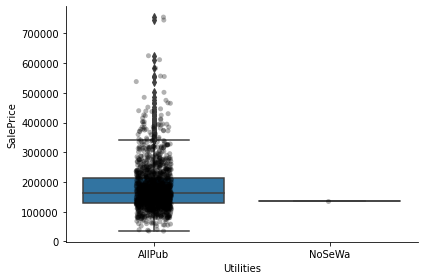

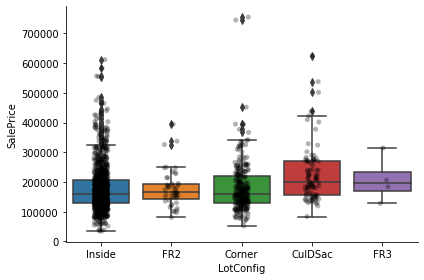

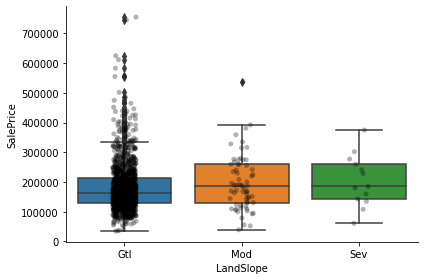

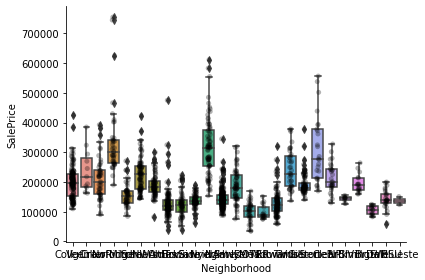

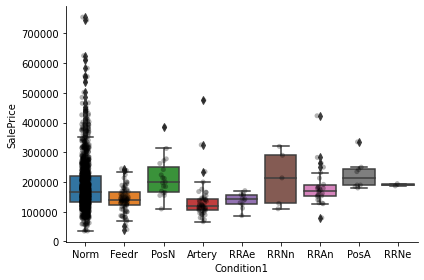

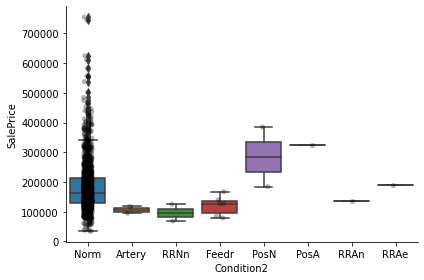

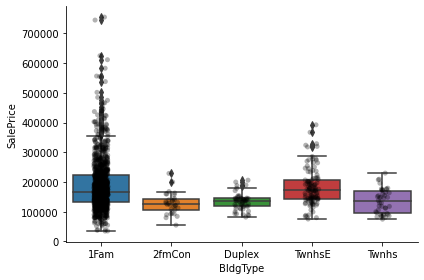

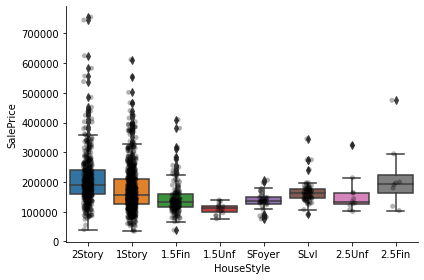

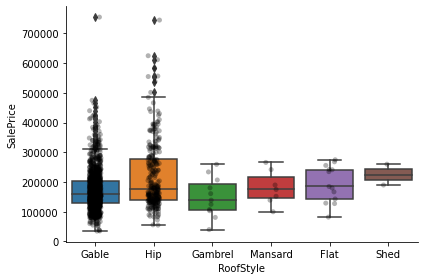

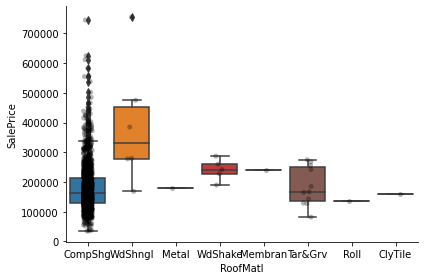

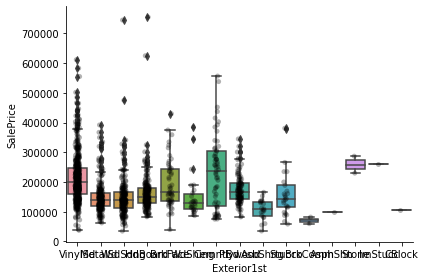

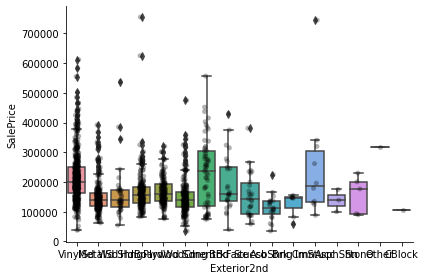

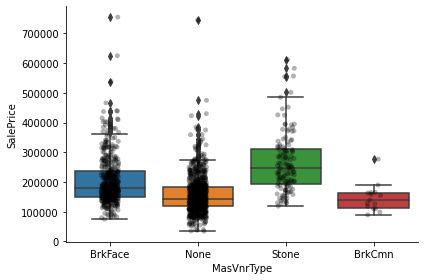

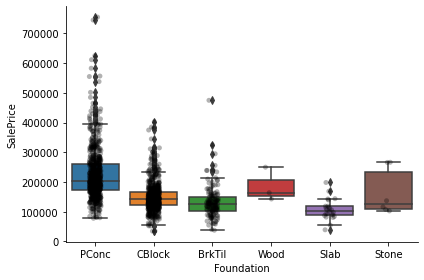

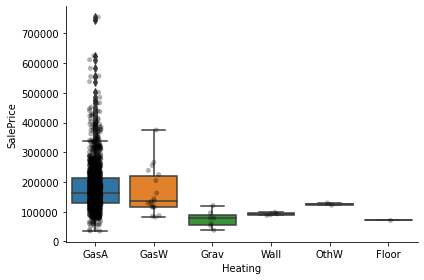

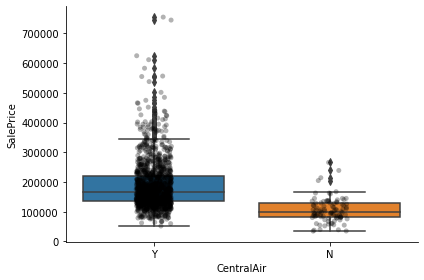

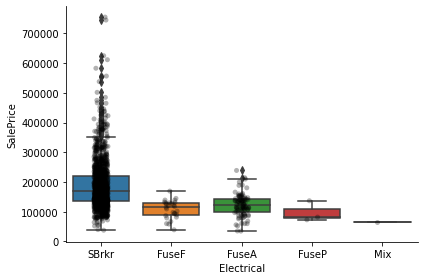

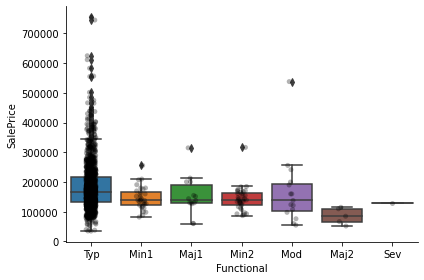

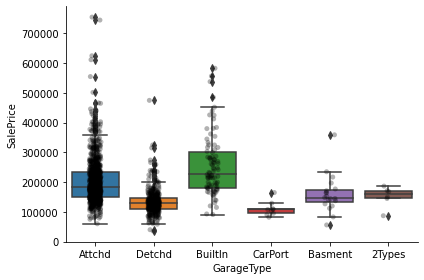

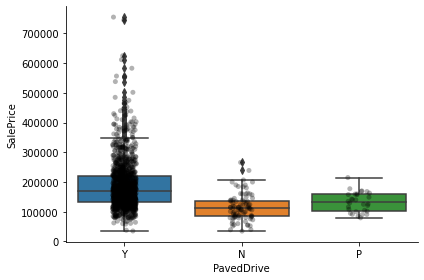

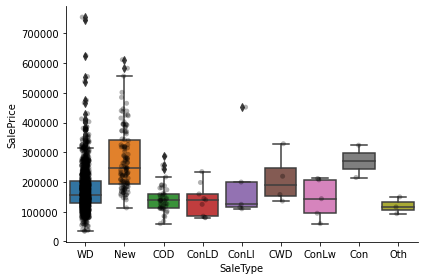

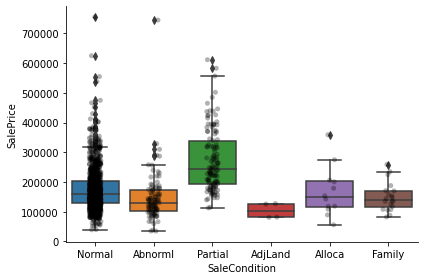

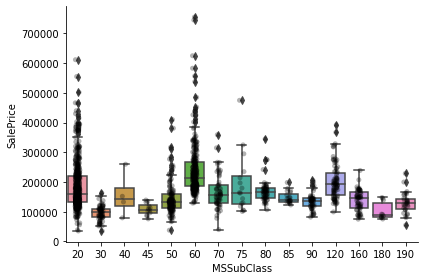

In [40]:
for var in cat_others:
    
    sns.catplot(x=var, y='SalePrice', data=data, kind="box", height=4, aspect=1.5)
    
    sns.stripplot(x=var, y='SalePrice', data=data, jitter=0.1, alpha=0.3, color='k')
    plt.show()

Jelas, kategori memberikan informasi tentang HargaSale, karena kategori yang berbeda menunjukkan harga jual rata-rata yang berbeda.

# Preprocessing

In [41]:
cat_vars_with_na = [
    var for var in cat_vars
    if data[var].isnull().sum() > 0
]

cat_vars_with_na

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [42]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if data[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if data[var].isnull().mean() < 0.1]

In [43]:
with_string_missing

['FireplaceQu']

In [44]:
with_frequent_category

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [45]:
data[with_string_missing] = data[with_string_missing].fillna('Missing')

In [46]:
for var in with_frequent_category:
    
    # there can be more than 1 mode in a variable
    # we take the first one with [0]    
    mode = data[var].mode()[0]
    
    print(var, mode)
    
    data[var].fillna(mode, inplace=True)

MasVnrType None
BsmtQual 3.0
BsmtCond 3.0
BsmtExposure 1.0
BsmtFinType1 1.0
BsmtFinType2 1.0
Electrical SBrkr
GarageType Attchd
GarageFinish 1.0
GarageQual 3.0
GarageCond 3.0


In [47]:
# check 
data[cat_vars_with_na].isnull().sum()

MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

### Variabel numerik

Untuk merekayasa nilai yang hilang dalam variabel numerik, kami akan:

- tambahkan variabel indikator biner yang hilang
- lalu ganti nilai yang hilang dalam variabel asli dengan rata-rata

In [48]:
num_vars = [
    var for var in data.columns if var not in cat_vars and var != 'SalePrice'
]


len(num_vars)

35

In [49]:
vars_with_na = [
    var for var in num_vars
    if data[var].isnull().sum() > 0
]

# print percentage of missing values per variable
data[vars_with_na].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

In [50]:
for var in vars_with_na:


    mean_val = data[var].mean()
    
    print(var, mean_val)

    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)
   
    data[var].fillna(mean_val, inplace=True)


# check that we have no more missing values in the engineered variables
data[vars_with_na].isnull().sum()

LotFrontage 70.04995836802665
MasVnrArea 103.68526170798899
GarageYrBlt 1978.5061638868744


LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [51]:
#check
[var for var in vars_with_na if data[var].isnull().sum() > 0]

[]

## Temporal variables

### Capture elapsed time

In [52]:
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

In [53]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

In [54]:
# now we drop YrSold
data.drop(['YrSold'], axis=1, inplace=True)

In [55]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,5,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4.0,3.0,1.0,6.0,706,1.0,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,Missing,Attchd,5.0,2.0,2,548,3.0,3.0,Y,0,61,0,0,0,0,0,2,WD,Normal,208500,0,0,0
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,31,31,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4.0,3.0,4.0,5.0,978,1.0,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3.0,Attchd,31.0,2.0,2,460,3.0,3.0,Y,298,0,0,0,0,0,0,5,WD,Normal,181500,0,0,0
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,7,6,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4.0,3.0,2.0,6.0,486,1.0,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3.0,Attchd,7.0,2.0,2,608,3.0,3.0,Y,0,42,0,0,0,0,0,9,WD,Normal,223500,0,0,0
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,91,36,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3.0,4.0,1.0,5.0,216,1.0,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4.0,Detchd,8.0,1.0,3,642,3.0,3.0,Y,0,35,272,0,0,0,0,2,WD,Abnorml,140000,0,0,0
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,8,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4.0,3.0,3.0,6.0,655,1.0,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3.0,Attchd,8.0,2.0,3,836,3.0,3.0,Y,192,84,0,0,0,0,0,12,WD,Normal,250000,0,0,0


## Transformasi variabel numerik

### Transformasi logaritmik

In [56]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])

### Yeo-Johnson transformation

apply the Yeo-Johnson transformation to LotArea.

In [57]:
# the yeo-johnson transformation learns the best exponent to transform the variable
# it needs to learn it from the train set: 
data['LotArea'], param = stats.yeojohnson(data['LotArea'])


print(param)

0.03081854079393649


### Binarizazi Varible yang Skew

Ada beberapa variabel yang sangat skew

In [58]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:
    
    # map the variable values into 0 and 1
    data[var] = np.where(data[var]==0, 0, 1)

In [59]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,60,RL,4.174387,10.427531,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,5,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4.0,3.0,1.0,6.0,706,1.0,0,150,856,GasA,5,Y,SBrkr,6.752270,854,0,7.444249,1,0,2,1,3,1,4,8,Typ,0,Missing,Attchd,5.0,2.0,2,548,3.0,3.0,Y,0,61,0,0,0,0,0,2,WD,Normal,208500,0,0,0
1,20,RL,4.382027,10.596445,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,31,31,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4.0,3.0,4.0,5.0,978,1.0,0,284,1262,GasA,5,Y,SBrkr,7.140453,0,0,7.140453,0,1,2,0,3,1,3,6,Typ,1,3.0,Attchd,31.0,2.0,2,460,3.0,3.0,Y,298,0,0,0,0,0,0,5,WD,Normal,181500,0,0,0
2,60,RL,4.219508,10.807340,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,7,6,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4.0,3.0,2.0,6.0,486,1.0,0,434,920,GasA,5,Y,SBrkr,6.824374,866,0,7.487734,1,0,2,1,3,1,4,6,Typ,1,3.0,Attchd,7.0,2.0,2,608,3.0,3.0,Y,0,42,0,0,0,0,0,9,WD,Normal,223500,0,0,0
3,70,RL,4.094345,10.589519,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,91,36,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3.0,4.0,1.0,5.0,216,1.0,0,540,756,GasA,4,Y,SBrkr,6.867974,756,0,7.448334,1,0,1,0,3,1,4,7,Typ,1,4.0,Detchd,8.0,1.0,3,642,3.0,3.0,Y,0,35,1,0,0,0,0,2,WD,Abnorml,140000,0,0,0
4,60,RL,4.430817,11.124530,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,8,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4.0,3.0,3.0,6.0,655,1.0,0,490,1145,GasA,5,Y,SBrkr,7.043160,1053,0,7.695303,1,0,2,1,4,1,4,9,Typ,1,3.0,Attchd,8.0,2.0,3,836,3.0,3.0,Y,192,84,0,0,0,0,0,12,WD,Normal,250000,0,0,0


# Handle Rare Lables

In [60]:
# capture all quality variables

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish']

# capture the remaining categorical variables
# (those that we did not re-map)

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

27

In [61]:
def find_frequent_labels(df, var, rare_perc):
    

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_others:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(data, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')


MSZoning Index(['FV', 'RH', 'RL', 'RM'], dtype='object', name='MSZoning')

Street Index(['Pave'], dtype='object', name='Street')

LotShape Index(['IR1', 'IR2', 'Reg'], dtype='object', name='LotShape')

LandContour Index(['Bnk', 'HLS', 'Low', 'Lvl'], dtype='object', name='LandContour')

Utilities Index(['AllPub'], dtype='object', name='Utilities')

LotConfig Index(['Corner', 'CulDSac', 'FR2', 'Inside'], dtype='object', name='LotConfig')

LandSlope Index(['Gtl', 'Mod'], dtype='object', name='LandSlope')

Neighborhood Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber'],
      dtype='object', name='Neighborhood')

Condition1 Index(['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'], dtype='object', name='Condition1')

Condition2 Index(['Norm'], dtype='object', name='Condition2')

BldgType Ind

In [62]:
def replace_categories(data, var, target):
    
    tmp = data.copy()
    
    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = tmp.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    
    print(var, ordinal_label)
    print()

    # use the dictionary to replace the categorical strings by integers
    data[var] = data[var].map(ordinal_label)

In [63]:
for var in cat_others:
    replace_categories(data, var, 'SalePrice')

MSZoning {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Street {'Rare': 0, 'Pave': 1}

LotShape {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3}

LandContour {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}

Utilities {'Rare': 0, 'AllPub': 1}

LotConfig {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4}

LandSlope {'Gtl': 0, 'Mod': 1, 'Rare': 2}

Neighborhood {'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'BrkSide': 3, 'Edwards': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7, 'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'NWAmes': 11, 'Rare': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15, 'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19, 'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22}

Condition1 {'Artery': 0, 'Feedr': 1, 'Rare': 2, 'RRAn': 3, 'Norm': 4, 'PosN': 5}

Condition2 {'Rare': 0, 'Norm': 1}

BldgType {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, 'TwnhsE': 3, '1Fam': 4}

HouseStyle {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, 'SLvl': 3, '1Story': 4, '2Story': 5}

RoofStyle {'Gable': 0, 'Rare': 1, 'Hip

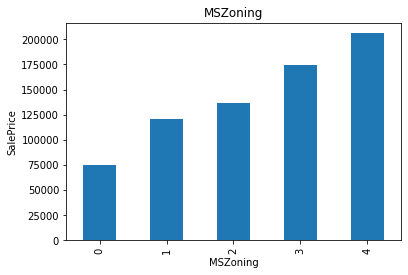

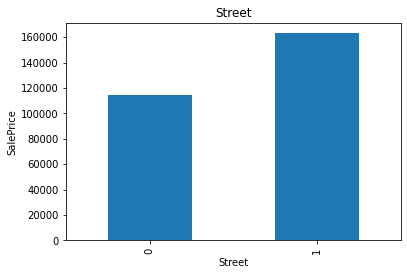

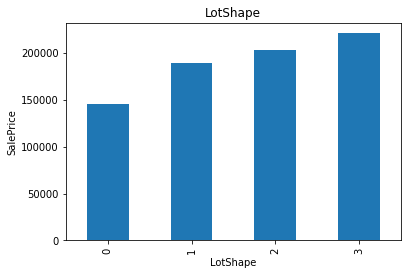

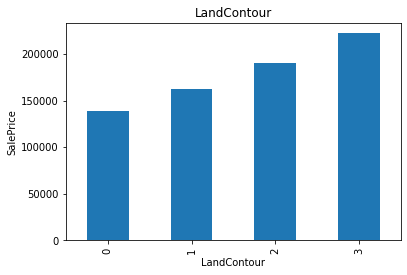

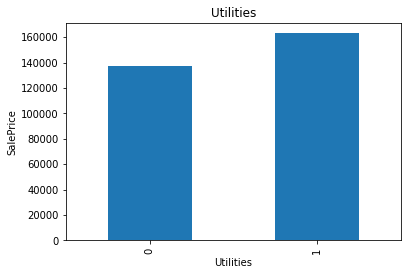

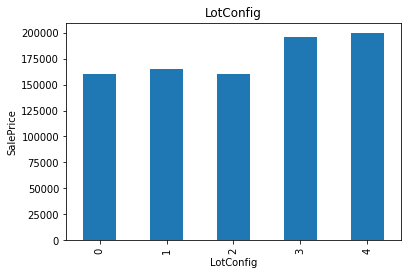

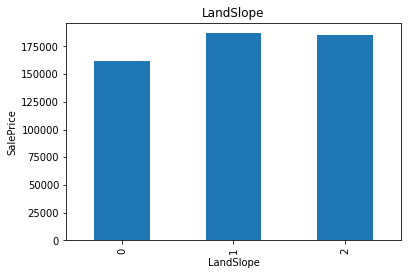

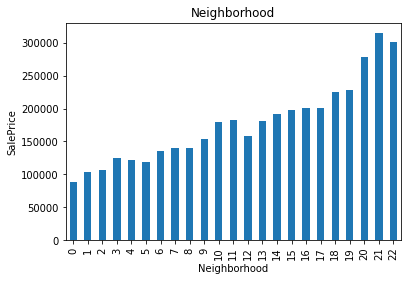

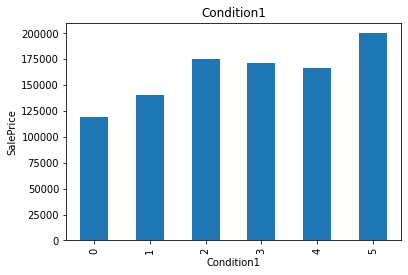

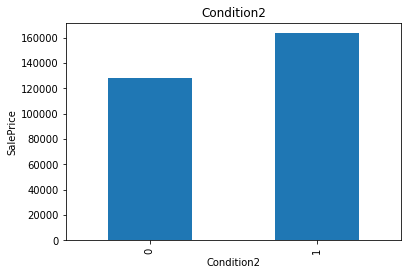

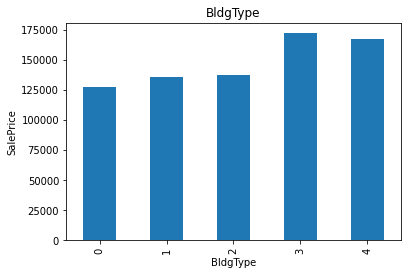

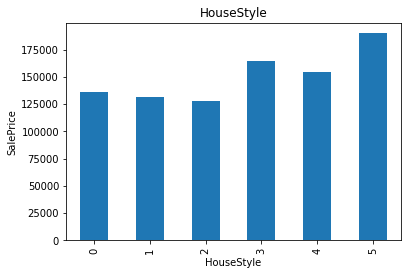

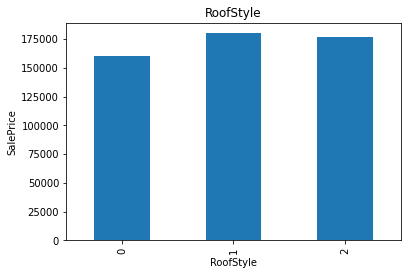

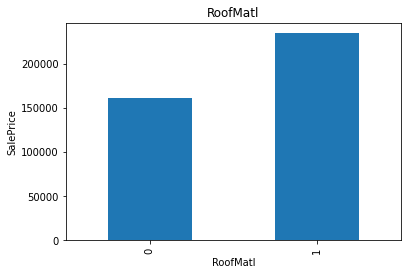

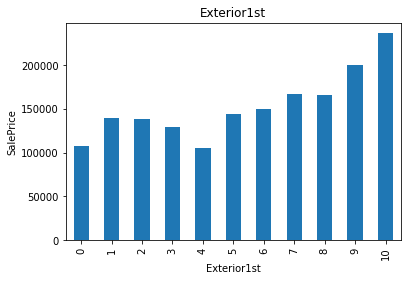

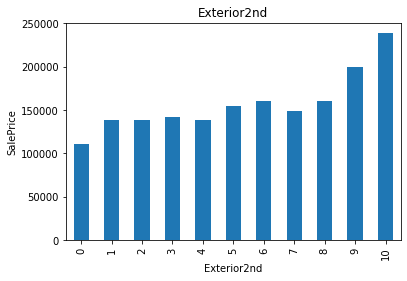

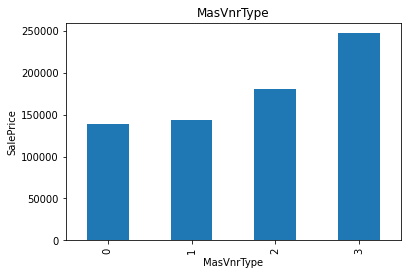

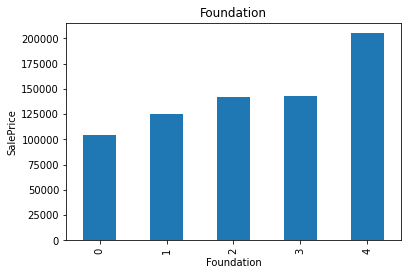

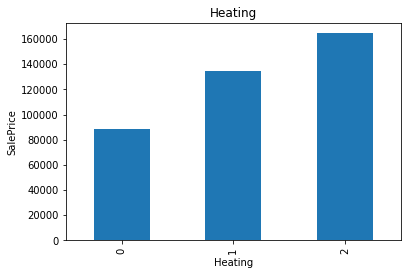

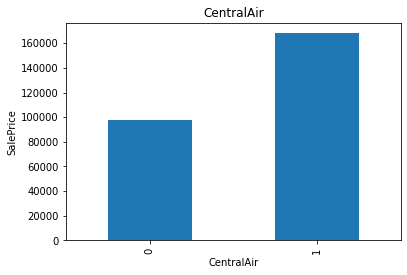

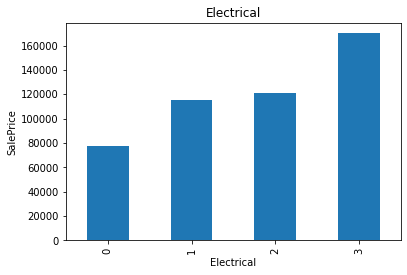

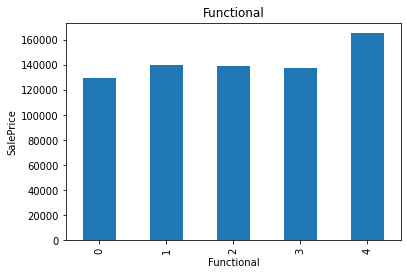

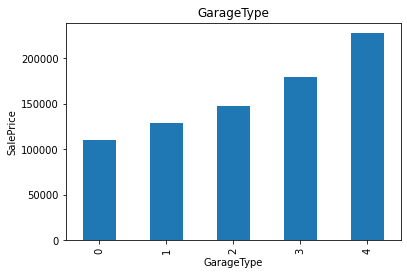

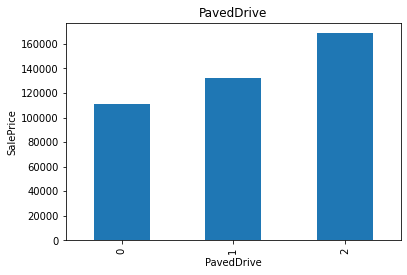

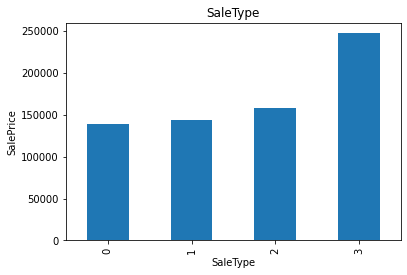

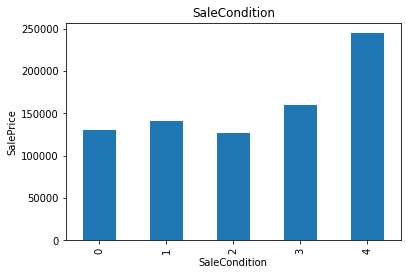

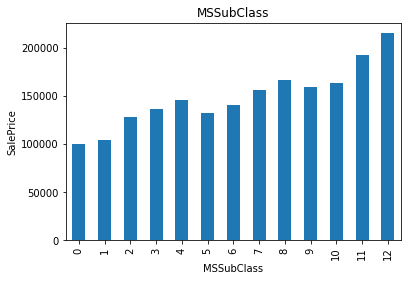

In [64]:
def analyse_vars(data,  var):
    
    # function plots median house sale price per encoded
    # category
    tmp = data.copy()
    tmp.groupby(var)['SalePrice'].median().plot.bar()
    plt.title(var)
    plt.ylabel('SalePrice')
    plt.show()
    
for var in cat_others:
    analyse_vars(data,  var)

Hubungan monoton sangat jelas untuk variabel MSZoning dan Neighborhood. Perhatikan, semakin tinggi bilangan bulat yang mewakili kategori, semakin tinggi harga rata-rata penjualan rumah.

# Target Transformation

<AxesSubplot: >

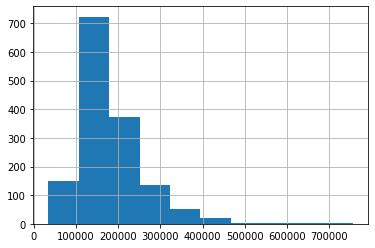

In [65]:
data["SalePrice"].hist()

In [66]:
data["SalePrice"] = np.log(data["SalePrice"])

<AxesSubplot: >

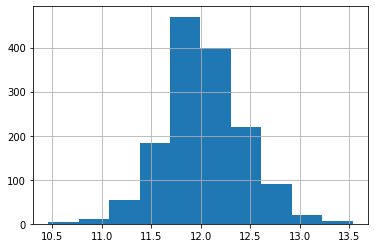

In [67]:
data["SalePrice"].hist()

# Feature Scalling

In [68]:
#lakukan feature scalling pada predictor numerik saja
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,12,3,4.174387,10.427531,1,0,1,1,0,0,15,4,1,4,5,7,5,5,5,0,0,9,9,2,196.0,4,3,4,4.0,3.0,1.0,6.0,706,1.0,0,150,856,2,5,1,3,6.752270,854,0,7.444249,1,0,2,1,3,1,4,8,4,0,Missing,3,5.0,2.0,2,548,3.0,3.0,2,0,61,0,0,0,0,0,2,2,3,12.247694,0,0,0
1,9,3,4.382027,10.596445,1,0,1,1,1,0,12,1,1,4,4,6,8,31,31,0,0,1,2,1,0.0,3,3,2,4.0,3.0,4.0,5.0,978,1.0,0,284,1262,2,5,1,3,7.140453,0,0,7.140453,0,1,2,0,3,1,3,6,4,1,3.0,3,31.0,2.0,2,460,3.0,3.0,2,298,0,0,0,0,0,0,5,2,3,12.109011,0,0,0
2,12,3,4.219508,10.807340,1,1,1,1,0,0,15,4,1,4,5,7,5,7,6,0,0,9,9,2,162.0,4,3,4,4.0,3.0,2.0,6.0,486,1.0,0,434,920,2,5,1,3,6.824374,866,0,7.487734,1,0,2,1,3,1,4,6,4,1,3.0,3,7.0,2.0,2,608,3.0,3.0,2,0,42,0,0,0,0,0,9,2,3,12.317167,0,0,0
3,7,3,4.094345,10.589519,1,1,1,1,2,0,16,4,1,4,5,7,5,91,36,0,0,2,4,1,0.0,3,3,1,3.0,4.0,1.0,5.0,216,1.0,0,540,756,2,4,1,3,6.867974,756,0,7.448334,1,0,1,0,3,1,4,7,4,1,4.0,1,8.0,1.0,3,642,3.0,3.0,2,0,35,1,0,0,0,0,2,2,0,11.849398,0,0,0
4,12,3,4.430817,11.124530,1,1,1,1,1,0,22,4,1,4,5,8,5,8,8,0,0,9,9,2,350.0,4,3,4,4.0,3.0,3.0,6.0,655,1.0,0,490,1145,2,5,1,3,7.043160,1053,0,7.695303,1,0,2,1,4,1,4,9,4,1,3.0,3,8.0,2.0,3,836,3.0,3.0,2,192,84,0,0,0,0,0,12,2,3,12.429216,0,0,0


In [69]:
data.groupby("FireplaceQu")["SalePrice"].median()

FireplaceQu
1.0        11.786581
2.0        11.970350
3.0        12.141534
4.0        12.240232
5.0        12.657936
Missing    11.813030
Name: SalePrice, dtype: float64

In [70]:
data = data.drop("FireplaceQu",axis=1)

In [71]:
# Define Predictor and Target
X = data.drop("SalePrice",axis=1).copy()
y = data["SalePrice"].copy()

In [72]:
#splitting data
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size=0.3,
                                                random_state=42)

In [73]:
# create scaler
scaler = MinMaxScaler()


#  fit  the scaler to predictor
scaler.fit(X_train) 


X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)


X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [74]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.750000,0.75,0.495064,0.388016,1.0,0.000000,0.333333,1.0,0.0,0.0,0.500000,0.8,1.0,1.00,0.8,0.666667,0.625,0.279412,0.639344,1.0,0.0,0.7,0.6,0.666667,0.208999,0.333333,0.5,1.0,0.333333,0.666667,0.000000,0.0,0.000000,0.0,0.0,0.558219,0.213421,1.0,0.75,1.0,1.0,0.611775,0.000000,0.0,0.571872,0.000000,0.0,0.666667,0.0,0.375,0.5,0.333333,0.416667,1.0,0.333333,0.75,0.355140,0.0,0.50,0.373766,0.5,0.5,1.0,0.114352,0.000000,0.0,0.0,0.0,0.0,0.0,0.363636,0.666667,0.75,0.0,0.0,0.0
1,0.083333,0.25,0.189077,0.190772,1.0,0.000000,0.333333,1.0,0.0,0.0,0.181818,0.8,1.0,0.75,0.6,0.444444,0.500,0.007353,0.032787,0.0,0.0,0.9,0.9,0.666667,0.058055,0.333333,0.5,1.0,0.666667,0.666667,1.000000,1.0,0.096917,0.0,0.0,0.000000,0.089525,1.0,0.75,1.0,1.0,0.441306,0.000000,0.0,0.412522,0.333333,0.0,0.333333,0.0,0.250,0.5,0.333333,0.250000,1.0,0.000000,0.50,0.009346,1.0,0.50,0.370240,0.5,0.5,1.0,0.000000,0.051188,0.0,0.0,0.0,0.0,0.0,0.363636,0.666667,0.75,0.0,0.0,0.0
2,1.000000,1.00,0.456066,0.352394,1.0,0.000000,0.333333,1.0,0.0,0.0,0.818182,0.8,1.0,1.00,1.0,0.666667,0.500,0.007353,0.032787,0.0,0.0,0.9,0.9,0.333333,0.000000,0.333333,0.5,1.0,0.666667,0.666667,0.333333,1.0,0.004252,0.0,0.0,0.313356,0.123732,1.0,1.00,1.0,1.0,0.313126,0.379177,0.0,0.542275,0.000000,0.0,0.666667,0.5,0.375,0.5,0.666667,0.416667,1.0,0.000000,0.75,0.009346,0.0,0.50,0.433004,0.5,0.5,1.0,0.197200,0.082267,0.0,0.0,0.0,0.0,0.0,0.454545,0.333333,0.75,0.0,0.0,0.0
3,0.750000,0.75,0.513123,0.410255,1.0,0.333333,0.333333,1.0,0.5,0.0,0.818182,0.4,1.0,1.00,0.8,0.888889,0.500,0.007353,0.032787,1.0,0.0,0.9,0.7,1.000000,0.219158,1.000000,0.5,1.0,1.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.815497,0.311784,1.0,1.00,1.0,1.0,0.658889,0.000000,0.0,0.615913,0.000000,0.0,0.666667,0.0,0.375,0.5,1.000000,0.500000,1.0,0.333333,0.75,0.009346,1.0,0.75,0.555712,0.5,0.5,1.0,0.000000,0.349177,0.0,0.0,0.0,0.0,0.0,0.181818,0.666667,0.75,0.0,0.0,0.0
4,1.000000,0.75,0.265271,0.392902,1.0,1.000000,0.333333,1.0,1.0,0.0,0.681818,1.0,1.0,1.00,1.0,0.666667,0.625,0.095588,0.229508,0.0,0.0,0.9,0.9,0.333333,0.000000,0.666667,0.5,1.0,0.666667,0.666667,0.666667,1.0,0.068214,0.8,1.0,0.029966,0.130769,1.0,1.00,1.0,1.0,0.343112,0.403874,0.0,0.567428,0.333333,0.0,0.666667,0.5,0.375,0.5,0.666667,0.333333,1.0,0.333333,0.75,0.121495,0.5,0.50,0.387870,0.5,0.5,1.0,0.184364,0.111517,0.0,0.0,0.0,0.0,0.0,0.272727,0.333333,0.75,0.0,0.0,0.0


# Feature Selection

Menggunakan Koefisien Lasso

In [78]:
# remember to set the seed, the random state in this function
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=42))

# train Lasso model and select features
sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=42))

In [79]:
sel_.get_support().sum()

37

In [80]:
selected_feats = X_train.columns[(sel_.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 76
selected features: 37
features with coefficients shrank to zero: 39


In [81]:
selected_feats

Index(['MSSubClass', 'MSZoning', 'LotArea', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'CentralAir',
       '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'GarageFinish', 'GarageCars', 'PavedDrive', 'WoodDeckSF', 'ScreenPorch',
       'SaleCondition', 'LotFrontage_na', 'GarageYrBlt_na'],
      dtype='object')

In [83]:
X_train = X_train[selected_feats]
X_test = X_test[selected_feats]

# Multicolinearity

<AxesSubplot: >

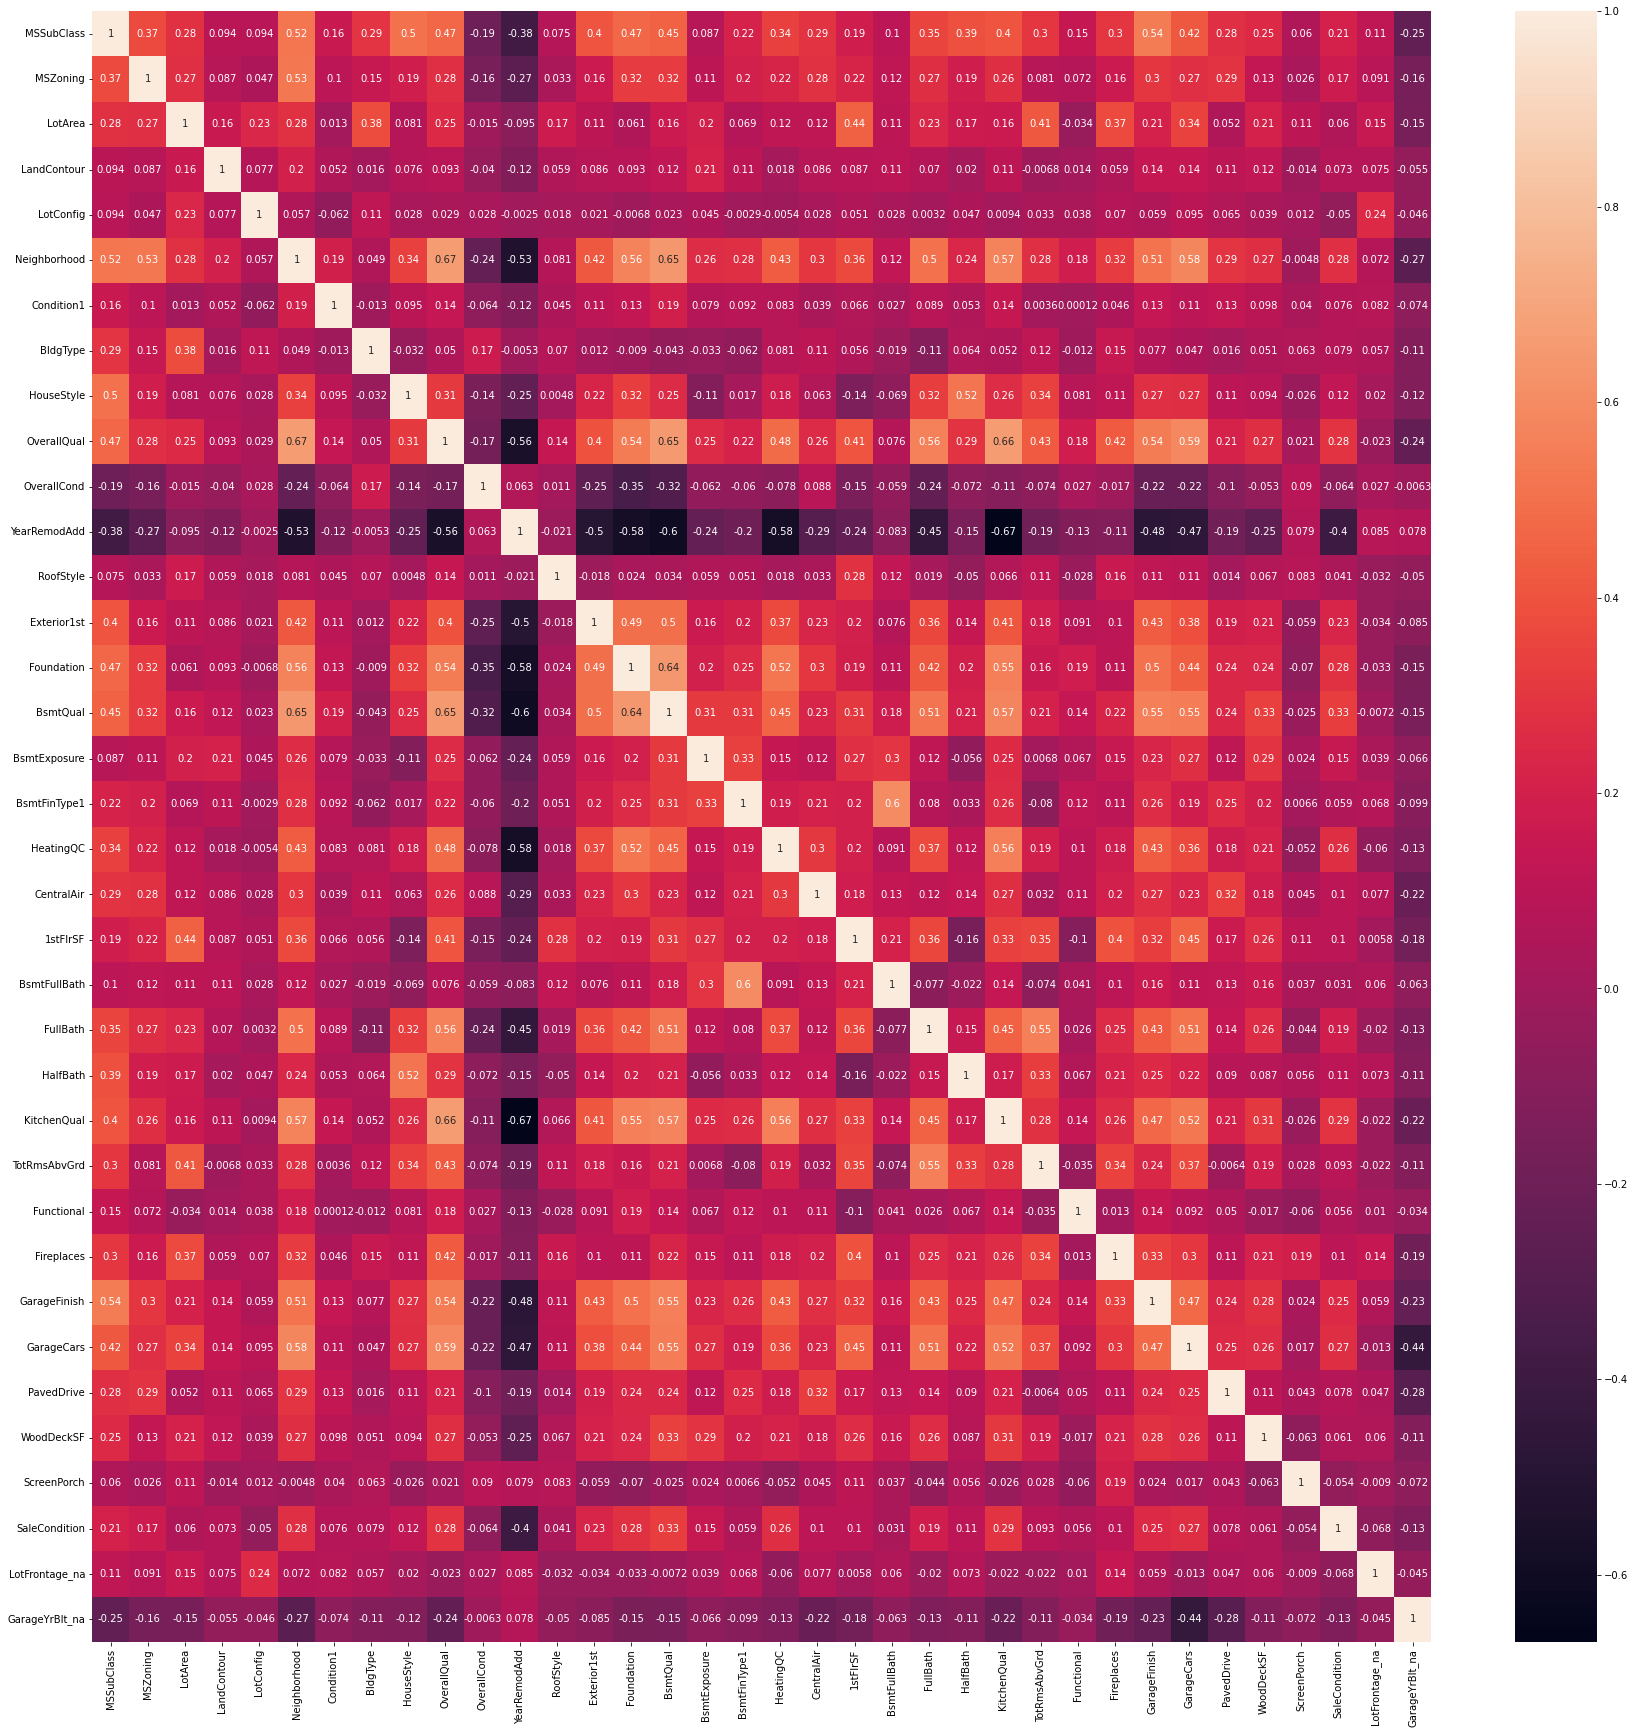

In [94]:
plt.figure(figsize=(30,30))

sns.heatmap(
    X_train.corr(method="spearman"),
    annot=True,
    fmt='.2g'
)

In [90]:
X_train = X_train.drop("GrLivArea",axis=1)
X_test = X_test.drop("GrLivArea",axis=1)

# Machine Learning

In [95]:
lin_model = Lasso(alpha=0.001, random_state=0)

# train the model

lin_model.fit(X_train, y_train)

Lasso(alpha=0.001, random_state=0)

In [96]:
# make predictions for train set
pred = lin_model.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = lin_model.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 835657954
train rmse: 28907
train r2: 0.8611535306416304

test mse: 774945114
test rmse: 27837
test r2: 0.8889460157385483

Average house price:  165000


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

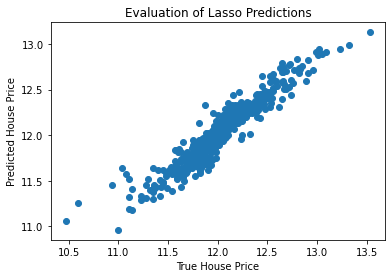

In [97]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, lin_model.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

In [104]:
y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(lin_model.predict(X_test))

preds

0      11.877042
1      12.703557
2      11.638662
3      11.942745
4      12.695661
         ...    
433    11.733758
434    11.697470
435    12.210108
436    11.849644
437    12.907745
Length: 438, dtype: float64

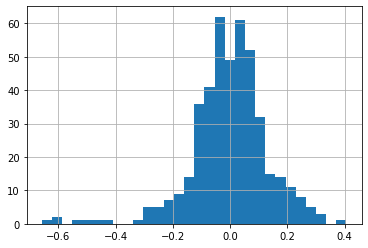

In [105]:
errors = y_test - preds
errors.hist(bins=30)
plt.show()

Distribusi residual mengikuti distribusi gaussian yang cukup dekat. Itu menunjukkan bahwa model melakukan pekerjaan dengan baik

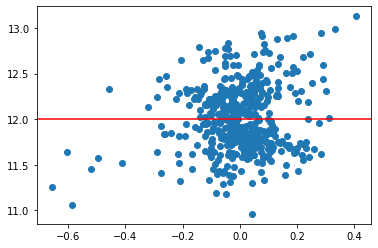

In [113]:
plt.scatter(errors,preds)
plt.axhline(y=12,color="r")

variance dari residual tidak menunjukkan kecendrungan pola tertentu

# Feature Importance

Text(0.5, 1.0, 'Feature Importance')

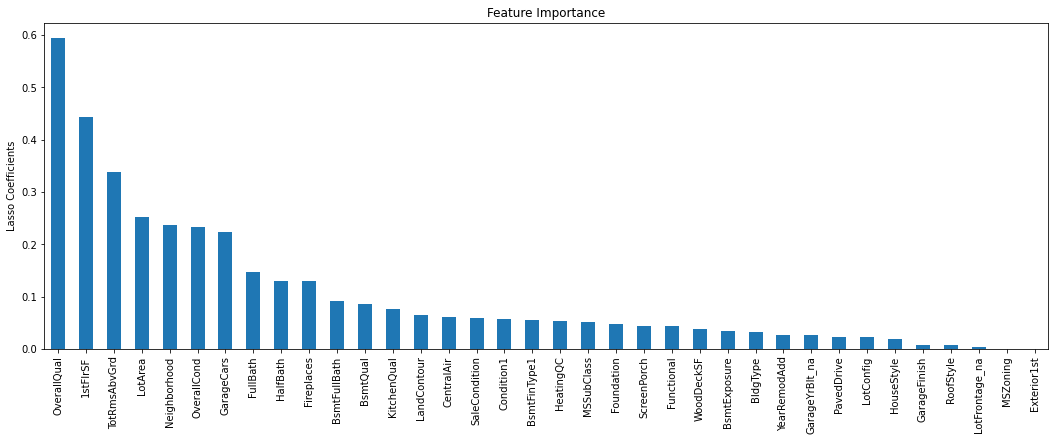

In [115]:
# Finally, just for fun, let's look at the feature importance

importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = X_train.columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

# Model WITH PCA

In [116]:
from sklearn.decomposition import PCA

In [117]:
# Create a PCA object
pca = PCA()

# Fit the PCA model to the data
pca.fit(X_train)

# Determine the number of components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"The optimal number of components is {n_components}")

# Transform the data using the optimal number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_train)

The optimal number of components is 26


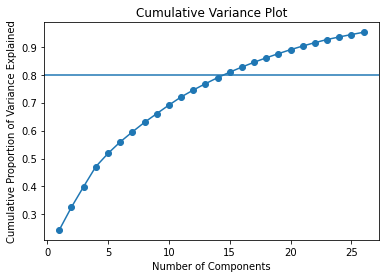

In [121]:
# Generate a cumulative variance plot
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title('Cumulative Variance Plot')
plt.axhline(y=0.8)
plt.show()

In [122]:
# Transform the data using the optimal number of components
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_train)

In [125]:
X_pca_test = pca.transform(X_test)

In [126]:
X_pca = pd.DataFrame(X_pca)
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.206860,-0.385792,-0.562082,0.639556,-0.028941,-0.194307,-0.310480,-0.220363,-0.222046,-0.372051,-0.053074,0.053830,0.006081,-0.104084,0.226197
1,-0.391408,0.367683,-0.277622,-0.899643,0.508522,-0.010711,0.464122,0.188167,0.304901,-0.383465,0.152589,0.009962,-0.241352,0.394438,-0.399104
2,-0.663655,-0.113170,0.066888,-0.532123,-0.338223,-0.248566,-0.354117,-0.207554,-0.500536,0.132469,0.028878,-0.202780,0.014875,-0.102814,0.077678
3,-0.958680,-0.672026,-0.449485,0.736685,0.366026,-0.187015,-0.189850,0.261442,0.328474,-0.072130,-0.050233,0.323112,0.082811,-0.071884,0.195884
4,-0.903089,0.266888,0.231343,-0.283155,0.049976,0.101217,-0.399938,0.623039,-0.263364,0.274192,-0.120534,-0.233772,-0.086071,0.054740,-0.070736


In [127]:
X_pca_test = pd.DataFrame(X_pca_test)
X_pca_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.002633,0.288817,-0.702728,0.218370,-0.423399,-0.408520,-0.025637,0.036350,0.253967,-0.153225,0.045768,-0.215370,-0.092110,0.002383,-0.366006
1,-1.025806,0.204006,0.062538,-0.280731,0.029981,0.265130,-0.161918,0.125715,-0.326712,0.449683,-0.259101,-0.100246,0.150402,-0.051392,0.266028
2,1.139150,-0.283226,-0.028094,-0.040118,0.035816,0.219851,-0.077840,-0.114115,0.201129,-0.207034,-0.246473,0.106768,0.256537,0.219246,0.157359
3,0.569506,0.226614,0.029926,-0.277498,-0.093399,0.124896,-0.382286,0.441546,0.377088,-0.331079,0.133161,0.190836,0.786433,-0.067406,0.130605
4,-1.440322,0.350946,-0.877700,-0.008478,0.515142,-0.050695,0.124862,-0.087031,-0.047730,-0.137475,-0.087572,0.016904,-0.027665,-0.094887,0.013741


In [129]:
y_train.reset_index(drop=True,inplace=True)

In [130]:
lin_model.fit(X_pca, y_train)

Lasso(alpha=0.001, random_state=0)